In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Shared imports for this notebook (method-specific imports stay near their cells).



In [2]:
import numpy as np
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

# Helper: summarize clustering results with context (cluster counts + metrics)
def summarize_clusters(labels, X=None, method_name="Clustering", noise_label=None):
    labels = np.asarray(labels)
    total = len(labels)

    # Identify noise points (if applicable)
    if noise_label is None:
        noise_mask = np.zeros_like(labels, dtype=bool)
    else:
        noise_mask = labels == noise_label

    n_noise = int(noise_mask.sum())
    used_mask = ~noise_mask
    unique_labels = np.unique(labels[used_mask]) if used_mask.any() else []

    # Cluster sizes (excluding noise)
    if used_mask.any():
        cluster_ids, counts = np.unique(labels[used_mask], return_counts=True)
        size_map = dict(zip(cluster_ids.tolist(), counts.tolist()))
    else:
        size_map = {}

    print(f"\n[{method_name}]")
    print(f"Total points: {total}")
    if noise_label is not None:
        print(f"Noise points: {n_noise} ({n_noise / total:.2%})")
    print(f"Number of clusters (excluding noise): {len(unique_labels)}")
    print(f"Cluster sizes (excluding noise): {size_map}")

    # Metrics: compute on non-noise points when noise exists
    if X is not None and len(unique_labels) >= 2:
        X_eval = X[used_mask] if noise_label is not None else X
        labels_eval = labels[used_mask] if noise_label is not None else labels

        silhouette = silhouette_score(X_eval, labels_eval)
        davies_bouldin = davies_bouldin_score(X_eval, labels_eval)
        calinski_harabasz = calinski_harabasz_score(X_eval, labels_eval)

        print(f"Silhouette Score: {silhouette}")
        print(f"Davies-Bouldin Index: {davies_bouldin}")
        print(f"Calinski-Harabasz Index: {calinski_harabasz}")
    else:
        print("Metrics not computed (need at least 2 non-noise clusters).")


# Helper: pick best KMeans k by silhouette
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.decomposition import PCA

def select_best_kmeans(X, k_range, random_state=42):
    best = {"score": -1, "k": None}
    for k in k_range:
        labels = KMeans(n_clusters=k, random_state=random_state).fit_predict(X)
        if len(np.unique(labels)) < 2:
            continue
        score = silhouette_score(X, labels)
        if score > best["score"]:
            best.update({"score": score, "k": k})
    return best


# Helper: pick best agglomerative k by silhouette

def select_best_agglomerative(X, k_range, linkages=("ward",)):
    if isinstance(linkages, str):
        linkages = (linkages,)
    best = {"score": -1, "k": None, "linkage": None}
    for linkage in linkages:
        for k in k_range:
            labels = AgglomerativeClustering(n_clusters=k, linkage=linkage).fit_predict(X)
            if len(np.unique(labels)) < 2:
                continue
            score = silhouette_score(X, labels)
            if score > best["score"]:
                best.update({"score": score, "k": k, "linkage": linkage})
    return best


# Helper: pick best DBSCAN params under a noise cap

def select_best_dbscan(X, eps_values, min_samples_values, noise_cap=0.30):
    best = {"score": -1, "eps": None, "min_samples": None, "noise_pct": None}
    for eps in eps_values:
        for min_samples in min_samples_values:
            labels = DBSCAN(eps=eps, min_samples=min_samples).fit_predict(X)
            noise_mask = labels == -1
            noise_pct = noise_mask.mean()
            if noise_pct > noise_cap:
                continue
            if noise_mask.all():
                continue
            X_non_noise = X[~noise_mask]
            labels_non_noise = labels[~noise_mask]
            if len(np.unique(labels_non_noise)) < 2:
                continue
            score = silhouette_score(X_non_noise, labels_non_noise)
            if score > best["score"]:
                best.update({
                    "score": score,
                    "eps": eps,
                    "min_samples": min_samples,
                    "noise_pct": noise_pct,
                })
    return best


# Helper: reusable Georgia county map colored by cluster assignment.
# Works for any number of clusters and optionally highlights noise (e.g. DBSCAN).

def plot_ga_cluster_map(cluster_labels, county_names, title="Cluster Map of Georgia Counties",
                        shapefile_path='./Counties_Georgia/Counties_Georgia.shp',
                        noise_label=None):
    """Plot a Georgia county map color-coded by cluster assignment.

    Parameters
    ----------
    cluster_labels : array-like   – cluster id per data point
    county_names   : array-like   – county name per data point (same order)
    title          : str          – plot title
    shapefile_path : str          – path to Georgia shapefile
    noise_label    : int or None  – label treated as noise (e.g. -1 for DBSCAN)
    """
    import geopandas as gpd
    import matplotlib.pyplot as plt
    from matplotlib.lines import Line2D
    import pandas as pd
    import numpy as np

    geo_data = gpd.read_file(shapefile_path)
    cluster_df = pd.DataFrame({'County': county_names, 'Cluster': cluster_labels})
    geo_merged = geo_data.merge(cluster_df, how='left', left_on='NAME10', right_on='County')

    # Determine unique non-noise clusters
    unique_clusters = sorted([c for c in np.unique(cluster_labels) if c != noise_label])
    n_clusters = len(unique_clusters)

    # Auto-generate distinct colors via viridis
    cmap_colors = plt.cm.viridis(np.linspace(0, 0.9, max(n_clusters, 1)))
    color_map = {cluster: cmap_colors[i] for i, cluster in enumerate(unique_clusters)}
    if noise_label is not None:
        color_map[noise_label] = np.array([0.86, 0.77, 0.94, 1.0])  # light purple for noise

    not_in_dataset_color = '#CCC0F1'

    geo_merged['color'] = geo_merged['Cluster'].apply(
        lambda x: color_map.get(x, not_in_dataset_color)
    )

    # Build legend automatically
    legend_elements = []
    for cluster in unique_clusters:
        legend_elements.append(
            Line2D([0], [0], marker='o', color='w',
                   label=f'Cluster {cluster}',
                   markerfacecolor=color_map[cluster], markersize=10)
        )
    if noise_label is not None:
        legend_elements.append(
            Line2D([0], [0], marker='o', color='w', label='Noise',
                   markerfacecolor=color_map[noise_label], markersize=10)
        )
    legend_elements.append(
        Line2D([0], [0], marker='o', color='w', label='Not in Dataset',
               markerfacecolor=not_in_dataset_color, markersize=10)
    )

    fig, ax = plt.subplots(1, figsize=(12, 12))
    geo_merged.plot(color=geo_merged['color'], ax=ax, edgecolor='black', linewidth=1)
    ax.set_title(title)
    ax.axis('off')
    ax.legend(handles=legend_elements, loc='lower left')
    plt.tight_layout()
    plt.show()



In [3]:
fifty_coefficients_df = pd.read_csv('./Threshold_DBs/50_pivoted_model_coefficients_for_all_features.csv')
coefficients_df = pd.read_csv('./pivoted_model_coefficients_for_all_features.csv')


coefficients_df_cleaned = coefficients_df.dropna() 
originalDFSet = coefficients_df['County'].unique()
cleanedDF = coefficients_df_cleaned['County'].unique()

fifty_ds_cleaned = fifty_coefficients_df.dropna()
fifty_coefficients_df = fifty_coefficients_df['County'].unique()
fifty_ds_cleaned = fifty_ds_cleaned['County'].unique()

print(set(originalDFSet) - set(cleanedDF))
print(set(fifty_coefficients_df) - set(fifty_ds_cleaned))



{'Ben Hill', 'Bacon', 'Jenkins', 'Taliaferro', 'Montgomery', 'Jeff Davis'}
{'Long', 'Glascock', 'Chattooga', 'Franklin', 'Stephens', 'Towns', 'Clay', 'Jenkins', 'Mitchell', 'Quitman', 'Bulloch', 'Sumter', 'Cook', 'Union', 'Greene', 'Montgomery', 'Pike', 'Monroe', 'Upson', 'Lamar', 'Jones', 'Heard', 'Telfair', 'Atkinson', 'Jasper', 'Laurens', 'Calhoun', 'Stewart', 'Lee', 'Baker', 'Dawson', 'McIntosh', 'Jeff Davis', 'Webster', 'Ben Hill', 'Bacon', 'Morgan', 'Chattahoochee', 'Appling', 'Taliaferro', 'Putnam', 'Dodge'}


First Step: Visualizations and Principal Component Analysis 

Using PCA components: 5


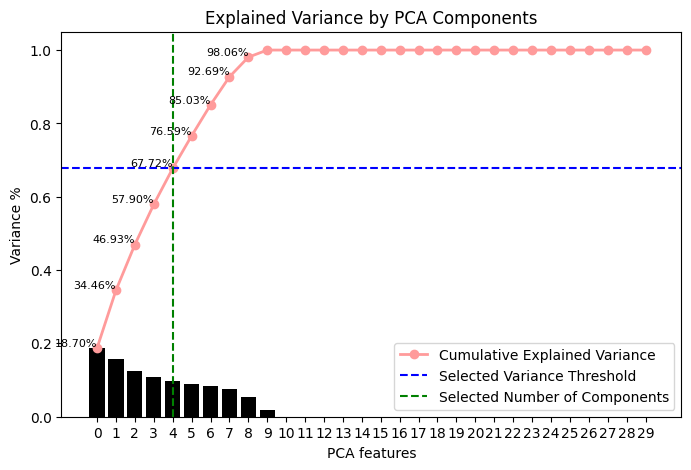

Selected components explain 67.72% variance: 5 components


In [4]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

features = coefficients_df_cleaned.columns.drop('County') 
X = coefficients_df_cleaned[features].values

# Use a fixed PCA component count for consistency with prior runs
PCA_COMPONENTS = 5
print(f"Using PCA components: {PCA_COMPONENTS}")

# Fit PCA and plot the individual explained variance
pca = PCA()
pca.fit(X)

features = range(pca.n_components_)
plt.figure(figsize=(8, 5))
plt.bar(features, pca.explained_variance_ratio_, color='black')
plt.xlabel('PCA features')
plt.ylabel('Variance %')
plt.xticks(features)
plt.title('Explained Variance by PCA Components')

# Calculate cumulative explained variance
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# Plot the cumulative explained variance trend line
plt.plot(features, cumulative_variance, color='#FF9B9B', marker='o', linestyle='-', linewidth=2, label='Cumulative Explained Variance')

# Annotate the points for the first 9 features or until cumulative variance reaches 100%
for i, v in enumerate(cumulative_variance):
    if v < 1.0 and i < 9:  # Check if the cumulative variance is less than 100% and within the first 9 features
        plt.text(i, v, f"{v:.2%}", fontsize=8, ha='right', va='bottom')

# Use the selected PCA component count to determine its explained variance
components_for_threshold = PCA_COMPONENTS
variance_threshold = cumulative_variance[components_for_threshold - 1]

# Add a horizontal line at the selected variance threshold
plt.axhline(y=variance_threshold, color='blue', linestyle='--', label='Selected Variance Threshold')

# Add a vertical line at the selected component count
plt.axvline(x=components_for_threshold - 1, color='green', linestyle='--', label='Selected Number of Components')

# Show the plot with legends
plt.legend()
plt.show()

# Print the variance explained by the selected number of components
print(f"Selected components explain {variance_threshold*100:.2f}% variance: {components_for_threshold} components")


In [5]:
import pandas as pd
from sklearn.decomposition import PCA

# Let's say 'X' is your dataset and 'features' is the list of column names
pca = PCA(n_components=PCA_COMPONENTS)
pca.fit(X)

# Create a DataFrame with the loadings
loadings = pd.DataFrame(
    pca.components_.T,
    columns=[f'PCA Component #{i+1}' for i in range(PCA_COMPONENTS)],
    index=features,
)

# Function to map each feature to its most contributing PCA component
def map_features_to_components(loadings_df):
    feature_component_map = {}
    for feature in loadings_df.index:
        dominant_component = loadings_df.loc[feature].abs().idxmax()
        if dominant_component in feature_component_map:
            feature_component_map[dominant_component].append(feature)
        else:
            feature_component_map[dominant_component] = [feature]
    return feature_component_map

# Map the features to components
features_mapped_to_components = map_features_to_components(loadings)

# Print the mapping
for component, features_list in features_mapped_to_components.items():
    # Ensure features are printed as strings for readability
    feature_names = [str(feature) for feature in features_list]
    print(f"{component} key features: {', '.join(feature_names)}")


PCA Component #2 key features: 0, 1, 2, 6, 7, 8, 12, 13, 14
PCA Component #5 key features: 3, 4, 5, 27, 28, 29
PCA Component #3 key features: 9, 10, 11, 24, 25, 26
PCA Component #1 key features: 15, 16, 17, 18, 19, 20
PCA Component #4 key features: 21, 22, 23


/Users/nikitajha/Documents/NikitaFinal/Coding Projects/Bastos Lab/my_new_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using UMAP components: 5


/Users/nikitajha/Documents/NikitaFinal/Coding Projects/Bastos Lab/my_new_env/lib/python3.9/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/var/folders/dr/13q6jns56rldkk1nfqpc25240000gn/T/ipykernel_15137/1324974801.py:22: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x=X_umap[:, 0], y=X_umap[:, 1], palette="viridis", legend='full')


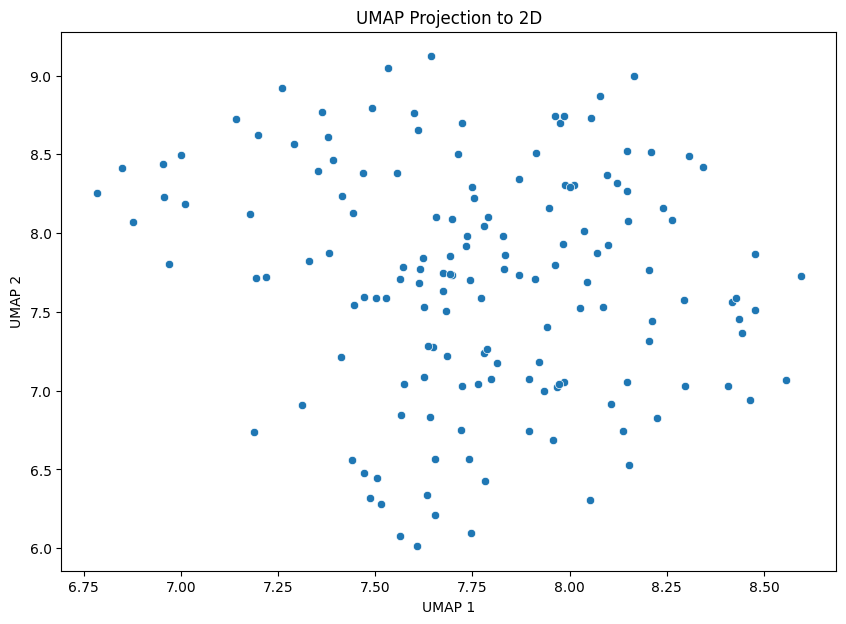

/var/folders/dr/13q6jns56rldkk1nfqpc25240000gn/T/ipykernel_15137/1324974801.py:32: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(X_umap[:, 0], X_umap[:, 1], X_umap[:, 2], cmap='viridis', edgecolor='k')


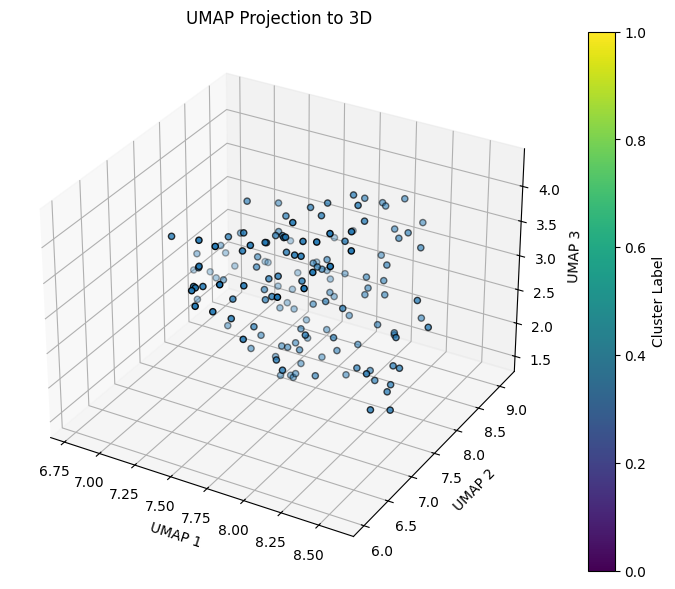

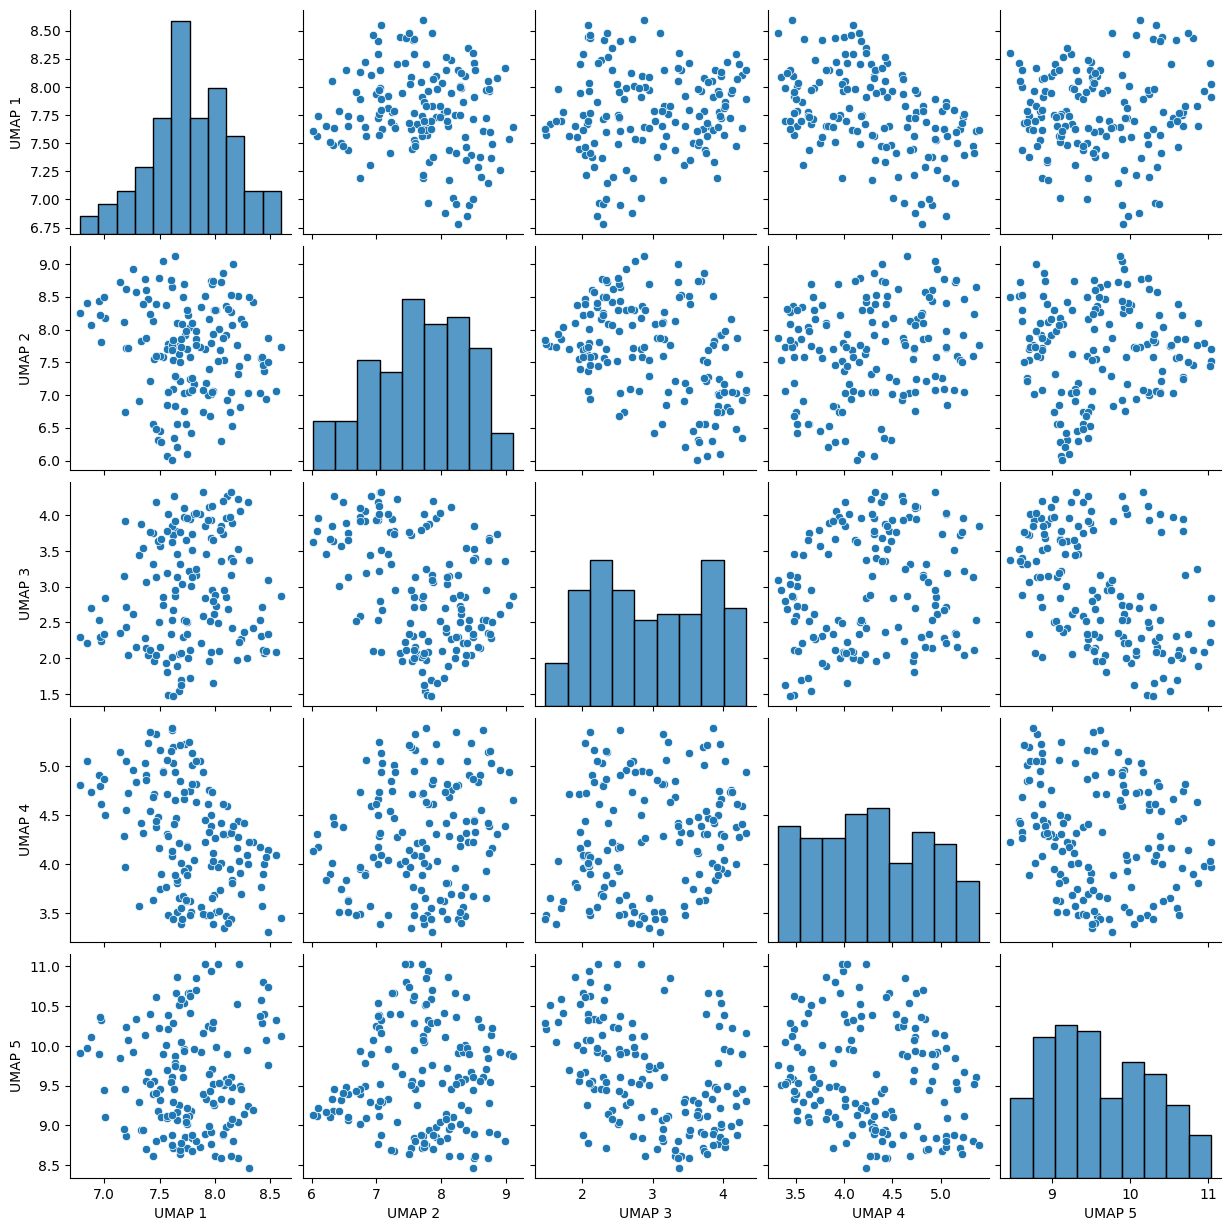

In [6]:
import umap
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import pandas as pd

features_to_scale = coefficients_df_cleaned.columns.drop('County')

# Assuming 'X' is your dataset
X = coefficients_df_cleaned[features_to_scale].values

# Use fixed UMAP components for consistency with prior runs
UMAP_COMPONENTS = 5
print(f"Using UMAP components: {UMAP_COMPONENTS}")

reducer = umap.UMAP(n_components=UMAP_COMPONENTS, random_state=42)
X_umap = reducer.fit_transform(X)

# For visualization, we can only plot in 2D or 3D directly.
# Let's plot the first 2 components as an example.
plt.figure(figsize=(10, 7))
sns.scatterplot(x=X_umap[:, 0], y=X_umap[:, 1], palette="viridis", legend='full')
plt.title('UMAP Projection to 2D')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.show()

# And a 3D plot for the first three components (only if we have >= 3)
if UMAP_COMPONENTS >= 3:
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')
    scatter = ax.scatter(X_umap[:, 0], X_umap[:, 1], X_umap[:, 2], cmap='viridis', edgecolor='k')
    ax.set_xlabel('UMAP 1')
    ax.set_ylabel('UMAP 2')
    ax.set_zlabel('UMAP 3')
    plt.colorbar(scatter, label='Cluster Label')
    plt.title('UMAP Projection to 3D')
    plt.show()
else:
    print("Skipping 3D plot: UMAP returned fewer than 3 components.")


# Create a DataFrame from the UMAP output for easier plotting
umap_df = pd.DataFrame(X_umap, columns=[f'UMAP {i+1}' for i in range(UMAP_COMPONENTS)])

# Use seaborn's pairplot to visualize the distribution and relationship of components
sns.pairplot(umap_df)
plt.show()


Second Step: Clustering 

Determined the optimal number of clusters using nbclust package: R, elbow method, sillhouette scores graph 

/Users/nikitajha/Documents/NikitaFinal/Coding Projects/Bastos Lab/my_new_env/lib/python3.9/site-packages/threadpoolctl.py:1019: RuntimeWarning: libc not found. The ctypes module in Python 3.9 is maybe too old for this OS.
  warnings.warn(


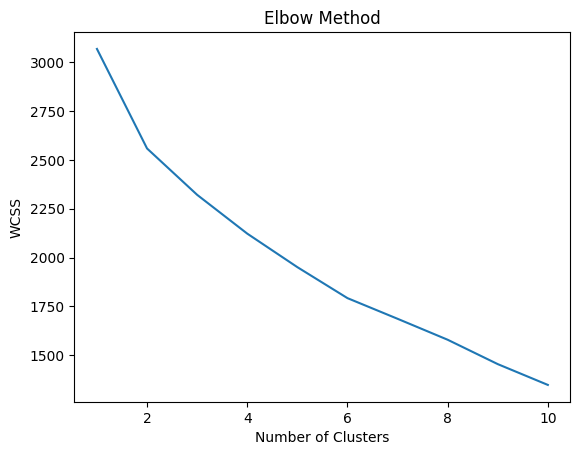

In [7]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

coefficients_df_cleaned = coefficients_df.dropna() 

features_to_scale = coefficients_df_cleaned.columns.drop('County')
#Perform PCA to reduce dimensionality 
X = coefficients_df_cleaned[features_to_scale].values
pca = PCA(n_components=PCA_COMPONENTS)
X_pca = pca.fit_transform(X)

wcss = []
for i in range(1, 11): 
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(X_pca)
    wcss.append(kmeans.inertia_)

plt.plot(range(1,11), wcss)
plt.title("Elbow Method")
plt.xlabel('Number of Clusters')
plt.ylabel("WCSS")
plt.show() 

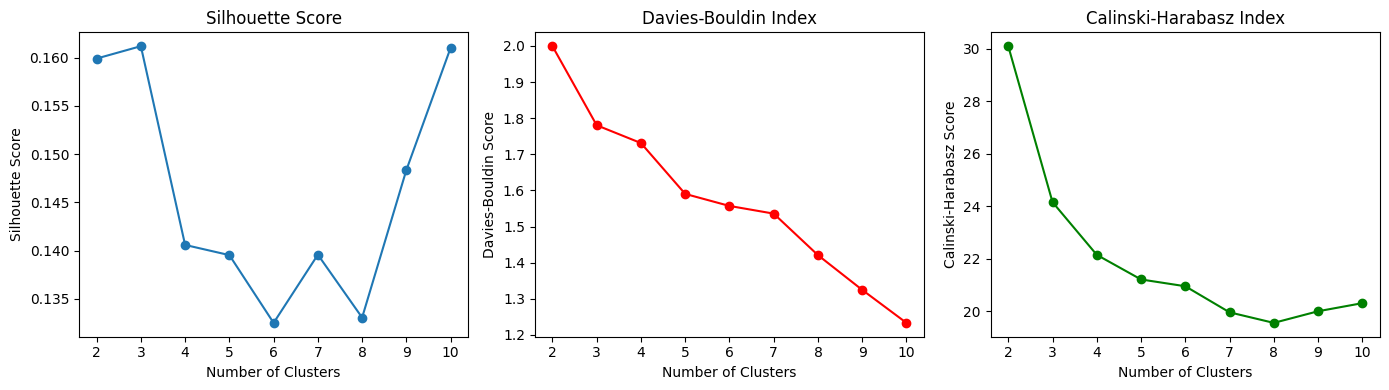

In [8]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import matplotlib.pyplot as plt
import numpy as np

X = coefficients_df_cleaned[features_to_scale].values
pca = PCA(n_components=PCA_COMPONENTS)
X_pca = pca.fit_transform(X)
X = X_pca

# Prepare lists to store the scores
silhouette_scores = []
davies_bouldin_scores = []
calinski_harabasz_scores = []

# Range of cluster numbers to try
n_clusters_range = range(2, 11)

for n_clusters in n_clusters_range:
    # Perform KMeans clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(X)

    # Compute the metrics
    silhouette_avg = silhouette_score(X, cluster_labels)
    davies_bouldin = davies_bouldin_score(X, cluster_labels)
    calinski_harabasz = calinski_harabasz_score(X, cluster_labels)

    # Store the scores
    silhouette_scores.append(silhouette_avg)
    davies_bouldin_scores.append(davies_bouldin)
    calinski_harabasz_scores.append(calinski_harabasz)

# Plot the Silhouette Score
plt.figure(figsize=(14, 4))
plt.subplot(131)
plt.plot(n_clusters_range, silhouette_scores, marker='o')
plt.title("Silhouette Score")
plt.xlabel('Number of Clusters')
plt.ylabel("Silhouette Score")

# Plot the Davies-Bouldin Index (remember, for this metric, lower is better)
plt.subplot(132)
plt.plot(n_clusters_range, davies_bouldin_scores, marker='o', color='r')
plt.title("Davies-Bouldin Index")
plt.xlabel('Number of Clusters')
plt.ylabel("Davies-Bouldin Score")

# Plot the Calinski-Harabasz Index
plt.subplot(133)
plt.plot(n_clusters_range, calinski_harabasz_scores, marker='o', color='g')
plt.title("Calinski-Harabasz Index")
plt.xlabel('Number of Clusters')
plt.ylabel("Calinski-Harabasz Score")

plt.tight_layout()
plt.show()


Best KMeans k: 3  (silhouette=0.1612)
Silhouette Score: 0.1612073892879878
Davies-Bouldin Index: 1.7803811973078896
Calinski-Harabasz Index: 24.15581740671971

[KMeans (PCA 5D, k=3)]
Total points: 153
Number of clusters (excluding noise): 3
Cluster sizes (excluding noise): {0: 69, 1: 69, 2: 15}
Silhouette Score: 0.1612073892879878
Davies-Bouldin Index: 1.7803811973078896
Calinski-Harabasz Index: 24.15581740671971


/var/folders/dr/13q6jns56rldkk1nfqpc25240000gn/T/ipykernel_15137/2211486456.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  coefficients_df_cleaned['Cluster'] = cluster_labels


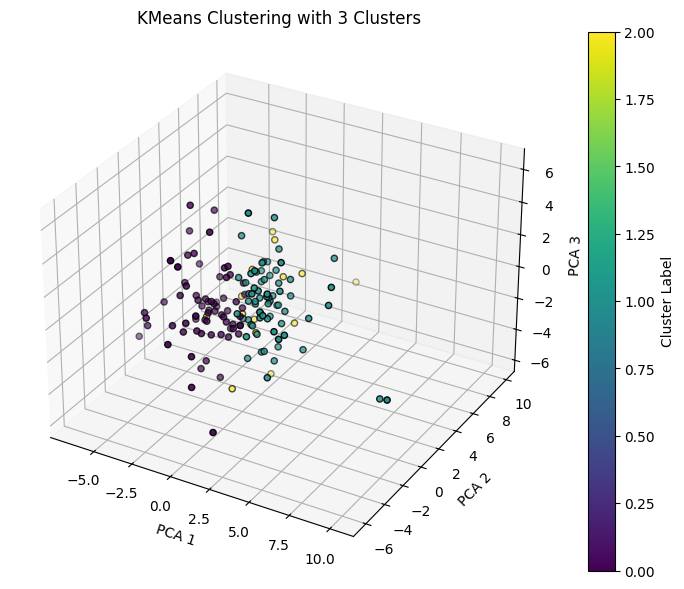

     cluster
0          0
1          1
2          2
3          0
4          1
..       ...
148        1
149        1
150        1
151        0
152        0

[153 rows x 1 columns]
cluster
0    69
1    69
2    15
dtype: int64


In [9]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

coefficients_df_cleaned = coefficients_df.dropna() 
features_to_scale = coefficients_df_cleaned.columns.drop('County') 

# Perform PCA to reduce dimensionality 
X = coefficients_df_cleaned[features_to_scale].values
pca = PCA(n_components=PCA_COMPONENTS)
X_pca = pca.fit_transform(X)

# Grid-search k by silhouette score.
# This is fast (just tries 9 values) and safe — always produces k clusters.
k_search = select_best_kmeans(X_pca, k_range=range(2, 11))
kmeans_k = k_search["k"]
print(f"Best KMeans k: {kmeans_k}  (silhouette={k_search['score']:.4f})")

# Initialize KMeans with the chosen number of clusters
kmeans = KMeans(n_clusters=kmeans_k, random_state=42)

# Fit the model and predict cluster indices
cluster_labels = kmeans.fit_predict(X_pca)

# Add the cluster labels to your original DataFrame for further analysis
coefficients_df_cleaned['Cluster'] = cluster_labels

# Calculate clustering performance metrics
silhouette = silhouette_score(X_pca, cluster_labels)
davies_bouldin = davies_bouldin_score(X_pca, cluster_labels)
calinski_harabasz = calinski_harabasz_score(X_pca, cluster_labels)

# Print the scores
print(f"Silhouette Score: {silhouette}")
print(f"Davies-Bouldin Index: {davies_bouldin}")
print(f"Calinski-Harabasz Index: {calinski_harabasz}")

# Add cluster-size context for interpretation
summarize_clusters(cluster_labels, X_pca, method_name=f"KMeans (PCA {PCA_COMPONENTS}D, k={kmeans_k})")

# Set up the figure and axis for 3D plotting
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot using the first three PCA components
scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=cluster_labels, cmap='viridis', edgecolor='k')

# Add labels and title
ax.set_xlabel('PCA 1')
ax.set_ylabel('PCA 2')
ax.set_zlabel('PCA 3')
plt.colorbar(scatter, label='Cluster Label')
plt.title(f'KMeans Clustering with {kmeans_k} Clusters')

plt.show()

# Create a new dataframe with the cluster labels
df_clusters = pd.DataFrame({'cluster': cluster_labels})

# Print the new dataframe
print(df_clusters)

# Print cluster counts
print(df_clusters.groupby('cluster').size())


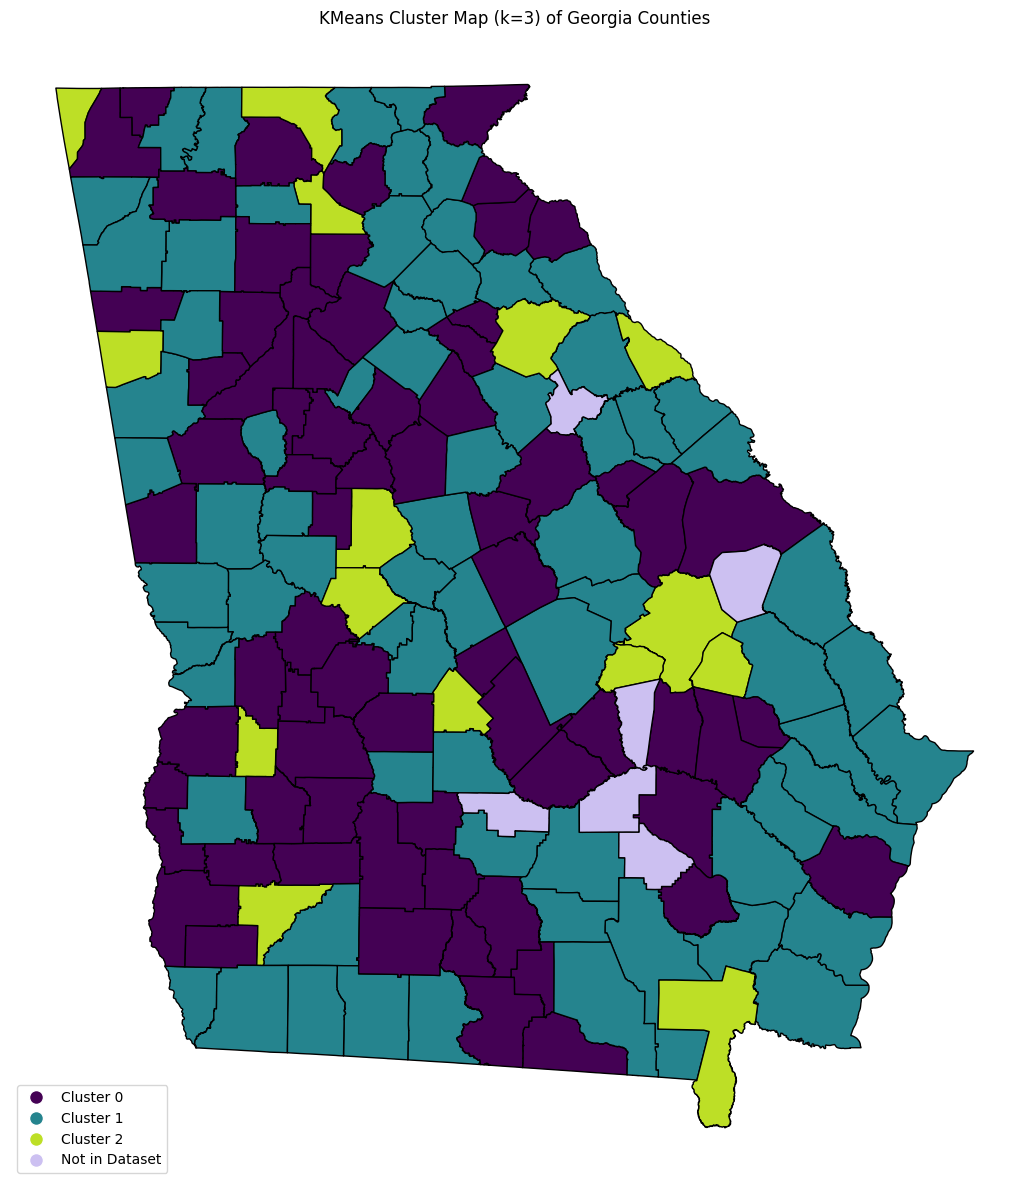

In [10]:
# Georgia map for KMeans clusters — uses the reusable helper so it works for any k
plot_ga_cluster_map(
    cluster_labels,
    coefficients_df_cleaned['County'].values,
    title=f'KMeans Cluster Map (k={kmeans_k}) of Georgia Counties',
)


In [11]:
import numpy as np

# Assuming X_pca is your PCA-reduced dataset
X = X_pca

# Define search ranges and noise cap
EPS_VALUES = np.arange(1, 10, 0.1)
MIN_SAMPLES_VALUES = range(2, 25)  # 2 * numDimensions
NOISE_CAP = 0.30

best_dbscan = select_best_dbscan(
    X,
    eps_values=EPS_VALUES,
    min_samples_values=MIN_SAMPLES_VALUES,
    noise_cap=NOISE_CAP,
)

print("DBSCAN best params under noise cap:")
print(
    f"Best Score: {best_dbscan['score']}, eps: {best_dbscan['eps']}, "
    f"min_samples: {best_dbscan['min_samples']}, noise_pct: {best_dbscan['noise_pct']:.2%}"
)

DBSCAN best params under noise cap:
Best Score: 0.4837441303204811, eps: 5.5000000000000036, min_samples: 2, noise_pct: 1.31%



[DBSCAN (PCA 5D)]
Total points: 153
Noise points: 2 (1.31%)
Number of clusters (excluding noise): 2
Cluster sizes (excluding noise): {0: 149, 1: 2}
Silhouette Score: 0.4837441303204811
Davies-Bouldin Index: 0.6560648440720702
Calinski-Harabasz Index: 11.131356570165961


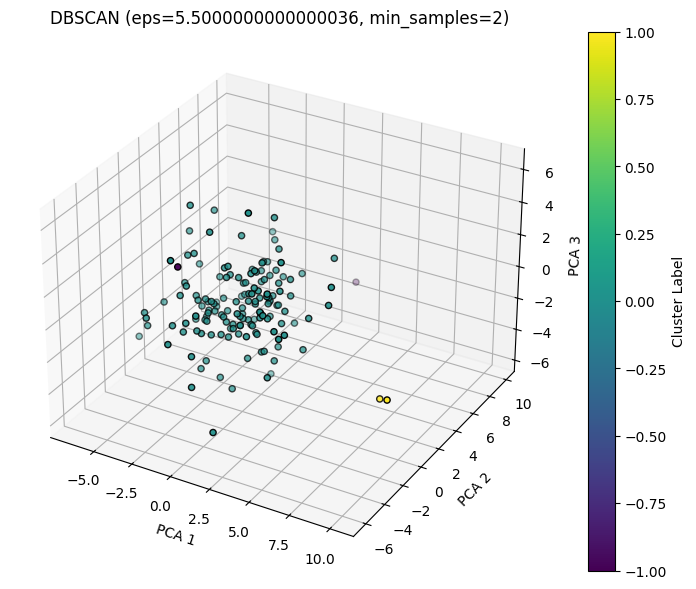

[ 0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0 -1  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0]


In [12]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN



# Assuming 'X' is your dataset
pca = PCA(n_components=PCA_COMPONENTS)
X_pca = pca.fit_transform(X)

# Run DBSCAN with best params from grid search
if best_dbscan["eps"] is None:
    raise ValueError("DBSCAN grid search found no valid params under noise cap.")

dbscan = DBSCAN(eps=best_dbscan["eps"], min_samples=best_dbscan["min_samples"])
clusters = dbscan.fit_predict(X_pca)

# Summary includes noise proportion (label -1) and metrics on non-noise points
summarize_clusters(clusters, X_pca, method_name=f"DBSCAN (PCA {PCA_COMPONENTS}D)", noise_label=-1)

from mpl_toolkits.mplot3d import Axes3D

# Set up the figure and axis for 3D plotting
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot using the first three PCA components
scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=clusters, cmap='viridis', edgecolor='k')

# Add labels and title
ax.set_xlabel('PCA 1')
ax.set_ylabel('PCA 2')
ax.set_zlabel('PCA 3')
plt.colorbar(scatter, label='Cluster Label')
plt.title(f'DBSCAN (eps={best_dbscan["eps"]}, min_samples={best_dbscan["min_samples"]})')

plt.show()

print(clusters)

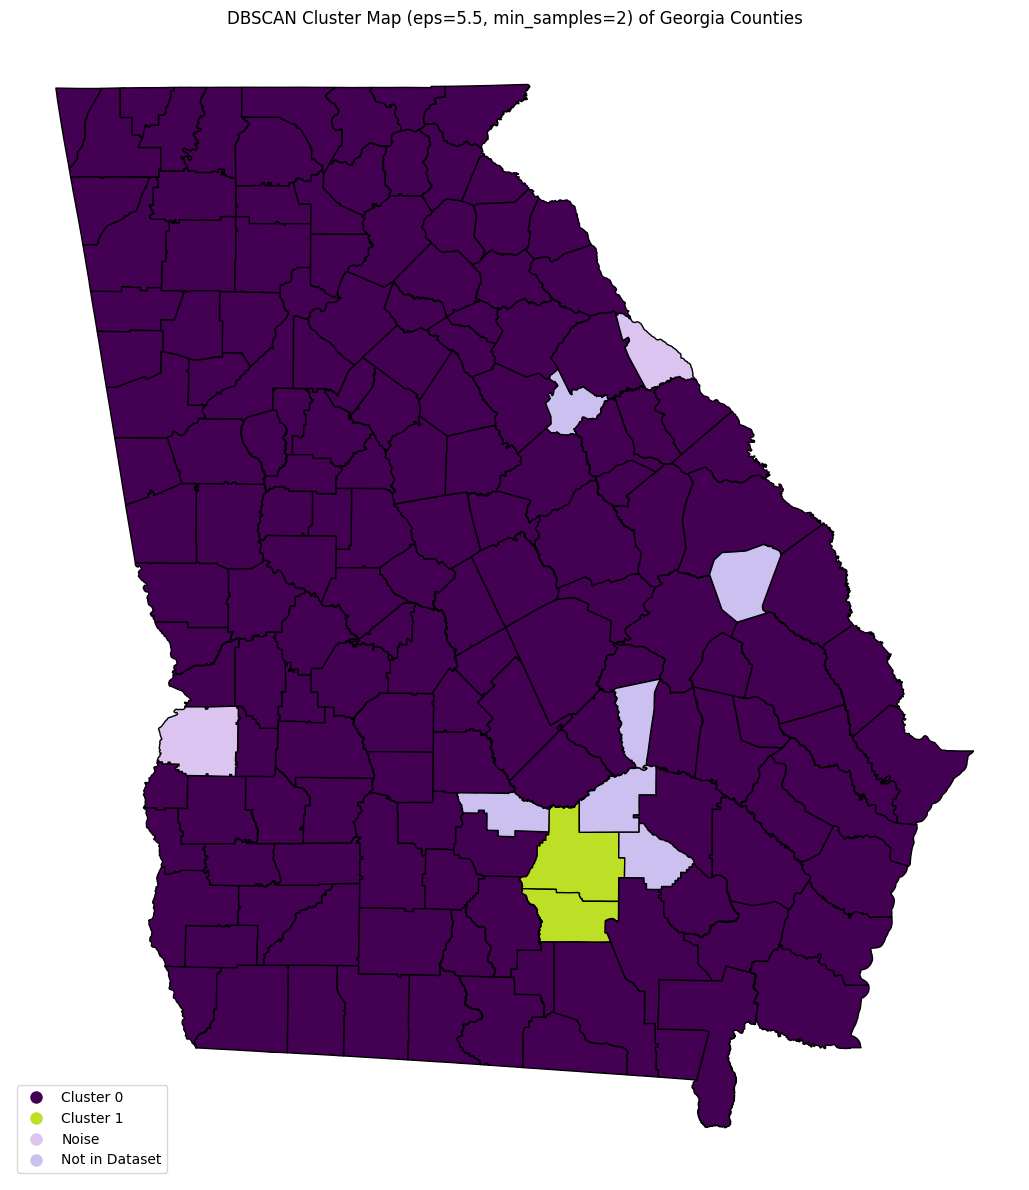

In [13]:
# Georgia map for DBSCAN clusters — handles noise label (-1) and any number of clusters
plot_ga_cluster_map(
    clusters,
    coefficients_df_cleaned['County'].values,
    title=f'DBSCAN Cluster Map (eps={best_dbscan["eps"]:.1f}, min_samples={best_dbscan["min_samples"]}) of Georgia Counties',
    noise_label=-1,
)

Hierarchical (Agglomerative) Clustering 

In [14]:
# (Grid search for Agglomerative k + linkage is now done directly in the next cell.)


Best Agglomerative: linkage=complete, k=2  (silhouette=0.4807)
[0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0]
Silhouette Score: 0.4807459895084211
Davies-Bouldin Index: 1.2889904616067178
Calinski-Harabasz Index: 10.00634876281533

[Agglomerative (complete, k=2)]
Total points: 153
Number of clusters (excluding noise): 2
Cluster sizes (excluding noise): {0: 150, 1: 3}
Silhouette Score: 0.4807459895084211
Davies-Bouldin Index: 1.2889904616067178
Calinski-Harabasz Index: 10.00634876281533


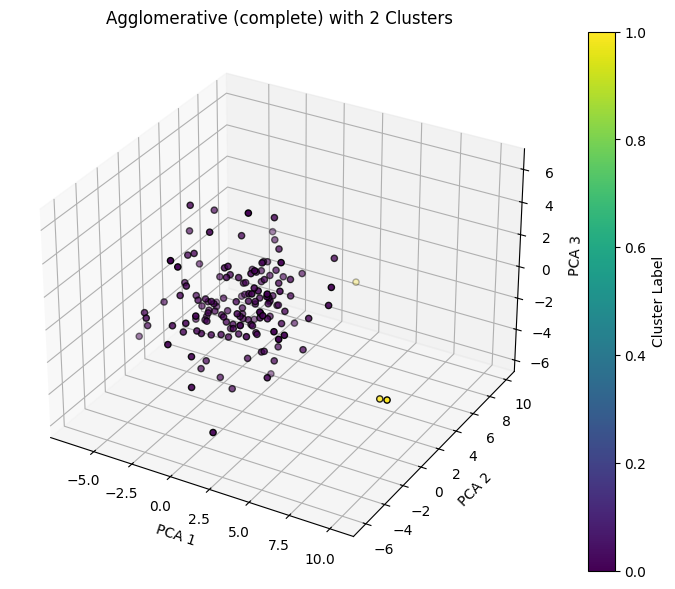

In [15]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Assuming X_pca is your PCA-reduced dataset

# Grid-search k and linkage by silhouette.
# Fast (9 k-values × 4 linkages = 36 combos) and safe — always produces k clusters.
linkage_options = ["ward", "complete", "average", "single"]
agg_search = select_best_agglomerative(X_pca, k_range=range(2, 11), linkages=linkage_options)
agg_linkage = agg_search["linkage"]
agg_k = agg_search["k"]
print(f"Best Agglomerative: linkage={agg_linkage}, k={agg_k}  (silhouette={agg_search['score']:.4f})")

# Step 3: Fit the hierarchical clustering
agg_clustering = AgglomerativeClustering(linkage=agg_linkage, n_clusters=agg_k, compute_full_tree=True)
agg_clustering.fit(X_pca)

# Step 5: Extract cluster labels
cluster_labels_agg = agg_clustering.labels_
print(cluster_labels_agg)

# Calculate clustering performance metrics
silhouette = silhouette_score(X_pca, cluster_labels_agg)
davies_bouldin = davies_bouldin_score(X_pca, cluster_labels_agg)
calinski_harabasz = calinski_harabasz_score(X_pca, cluster_labels_agg)

# Print the scores
print(f"Silhouette Score: {silhouette}")
print(f"Davies-Bouldin Index: {davies_bouldin}")
print(f"Calinski-Harabasz Index: {calinski_harabasz}")

# Add cluster-size context for interpretation
summarize_clusters(cluster_labels_agg, X_pca, method_name=f"Agglomerative ({agg_linkage}, k={agg_k})")

# Set up the figure and axis for 3D plotting
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot using the first three PCA components
scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=cluster_labels_agg, cmap='viridis', edgecolor='k')

# Add labels and title
ax.set_xlabel('PCA 1')
ax.set_ylabel('PCA 2')
ax.set_zlabel('PCA 3')
plt.colorbar(scatter, label='Cluster Label')
plt.title(f'Agglomerative ({agg_linkage}) with {agg_k} Clusters')

plt.show()


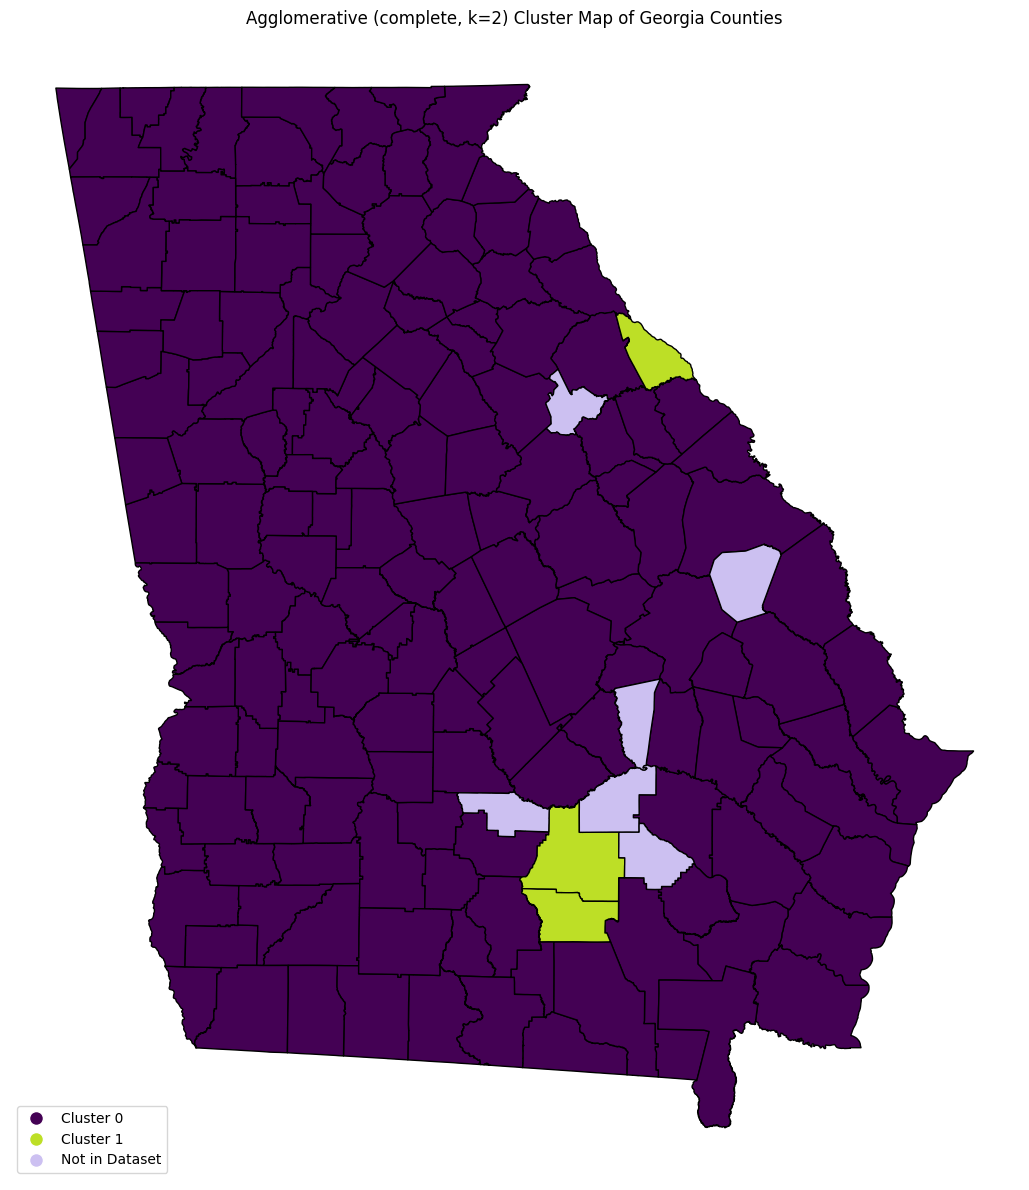

In [16]:
# Georgia map for Agglomerative clusters — works for any k and linkage
plot_ga_cluster_map(
    cluster_labels_agg,
    coefficients_df_cleaned['County'].values,
    title=f'Agglomerative ({agg_linkage}, k={agg_k}) Cluster Map of Georgia Counties',
)


In [17]:
import numpy as np
import pandas as pd
import torch
from sklearn.decomposition import PCA
from sklearn.neighbors import kneighbors_graph
from scipy.sparse import csr_matrix
import torch_geometric
from torch_geometric.data import Data

# Original DataFrame
feature_columns = coefficients_df_cleaned.columns.drop('County')
node_features = coefficients_df_cleaned[feature_columns].values

# Perform PCA using the selected component count
pca = PCA(n_components=PCA_COMPONENTS)
pca_features = pca.fit_transform(node_features)


# Convert PCA features to PyTorch tensor
pca_features = torch.tensor(pca_features, dtype=torch.float)

# Use a fixed k for KNN graph construction (consistency with prior runs)
KNN_K = 6
print(f"Using KNN k: {KNN_K}")

# Using k-nearest neighbors to construct edges based on PCA feature similarity
knn_graph = kneighbors_graph(pca_features.numpy(), KNN_K, mode='connectivity', include_self=False)

# Convert csr_matrix to COO (Coordinate) format to easily extract row and column indices
coo_graph = knn_graph.tocoo()

# Extract row and column indices which represent the edges
edge_index = torch.tensor(np.vstack((coo_graph.row, coo_graph.col)), dtype=torch.long)

# Create a graph data structure suitable for PyTorch Geometric GNN models
graph_data = Data(x=pca_features, edge_index=edge_index)

# Now, 'graph_data' is ready to be used as input to GNN models

Using KNN k: 6


In [18]:
import torch
import numpy as np
import random
from torch_geometric.nn import GCNConv
import torch.nn.functional as F
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.preprocessing import normalize as sklearn_normalize

# ---------------------------------------------------------------------------
# GCN grid search — searches learning rate and n_clusters.
#
# KEY FIXES vs. previous version (which caused embedding collapse):
#   1. ARCHITECTURE: Reduced from 4 → 2 GCN layers.  Deep GCNs on small
#      graphs (153 nodes) suffer from "over-smoothing" — each layer averages
#      a node's embedding with its neighbors, so after 4 layers every node
#      converges to the same value.  2 layers is the standard for small
#      graphs (Kipf & Welling 2017).
#   2. BATCH NORMALIZATION: Added after each GCN layer to stabilize
#      activations and prevent gradients from vanishing/exploding.
#   3. DROPOUT: Reduced from 0.5 → 0.2.  50% dropout on 153 nodes is too
#      aggressive — it randomly zeros half the signal every forward pass,
#      which on a small dataset means the model can never learn a stable
#      representation.
#   4. BOTTLENECK: Reduced latent dim from 64 → 16.  The input is only 5-D
#      (PCA features), so mapping to 64-D is a 13× EXPANSION that gives
#      KMeans too many noisy dimensions to exploit.  A 16-D bottleneck
#      forces the model to learn a compressed, informative representation.
#   5. LEARNING RATES: Lowered search range to [0.001, 0.005, 0.01].
#      lr=0.05 caused the loss to oscillate wildly (2.9 → 4.1 → 3.6)
#      without ever converging.
#   6. EVAL MODE: Switch to model.eval() before extracting embeddings so
#      dropout is disabled and batch norm uses running statistics.
#   7. L2 NORMALIZATION: Normalize embeddings to the unit hypersphere
#      before clustering, so KMeans operates on directions (angular
#      separation) rather than magnitudes — prevents scale-collapse
#      artifacts.
#   8. COLLAPSE DETECTION: Reject any (lr, k) combo where embedding std
#      is below 0.1 — these are collapsed and would produce fake clusters.
# ---------------------------------------------------------------------------

def set_seed(seed_value=42):
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed_value)

set_seed(42)


class GCNAutoEncoder(torch.nn.Module):
    """
    2-layer GCN encoder with BatchNorm + lightweight dropout.
    Bottleneck (out_channels) should be SMALLER than in_channels
    to force the model to learn a compressed representation.
    """
    def __init__(self, in_channels, hidden_channels, out_channels, dropout=0.2):
        super(GCNAutoEncoder, self).__init__()
        # Encoder: 2 GCN layers with BatchNorm
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.bn1 = torch.nn.BatchNorm1d(hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)
        self.bn2 = torch.nn.BatchNorm1d(out_channels)
        self.dropout = torch.nn.Dropout(dropout)
        # Decoder: linear projection back to input space
        self.decoder = torch.nn.Linear(out_channels, in_channels)

    def forward(self, x, edge_index):
        # Layer 1
        x = self.conv1(x, edge_index)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.dropout(x)
        # Layer 2 (bottleneck — no ReLU so latent can be negative)
        x = self.conv2(x, edge_index)
        x = self.bn2(x)
        latent = x
        # Decoder
        x_reconstructed = self.decoder(latent)
        return x_reconstructed, latent


# Architecture params
in_channels = graph_data.x.size(1)   # 5 (PCA)
GCN_HIDDEN = 64                       # wider intermediate layer for richer feature extraction
GCN_OUT_CHANNELS = 8                   # reduced bottleneck → better cluster separation in fewer dims
GCN_SEARCH_EPOCHS = 500
MIN_EMB_STD = 0.1                      # reject collapsed embeddings

print(f"GCN architecture: {in_channels} → {GCN_HIDDEN} → {GCN_OUT_CHANNELS} (bottleneck)")

# Grid search over lr and n_clusters
learning_rates = [0.001, 0.005, 0.01]
num_clusters_options = range(2, 8)

best_gcn_search = {
    'silhouette': -1,
    'davies_bouldin': None,
    'calinski_harabasz': None,
    'lr': None,
    'n_clusters': None,
    'emb_std': None,
}

for lr in learning_rates:
    set_seed(42)
    model = GCNAutoEncoder(in_channels, GCN_HIDDEN, GCN_OUT_CHANNELS)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
    loss_func = torch.nn.MSELoss()

    # --- Train ---
    model.train()
    for epoch in range(GCN_SEARCH_EPOCHS):
        optimizer.zero_grad()
        output, latent = model(graph_data.x, graph_data.edge_index)
        loss = loss_func(output, graph_data.x)
        loss.backward()
        optimizer.step()

    # --- Extract embeddings in EVAL mode (dropout off, BN uses running stats) ---
    model.eval()
    with torch.no_grad():
        _, latent = model(graph_data.x, graph_data.edge_index)
    embeddings_np = latent.numpy()

    # Check for collapse BEFORE clustering
    emb_std = embeddings_np.std(axis=0).mean()
    if emb_std < MIN_EMB_STD:
        print(f"  lr={lr}: SKIPPED — embeddings collapsed (std={emb_std:.4f})")
        continue

    # L2-normalize embeddings so KMeans uses angular separation
    embeddings_normed = sklearn_normalize(embeddings_np, norm='l2')

    # Try different k values on these fixed embeddings
    for n_clusters in num_clusters_options:
        labels = KMeans(n_clusters=n_clusters, random_state=42,
                        n_init=10).fit_predict(embeddings_normed)
        sil = silhouette_score(embeddings_normed, labels)
        dbi = davies_bouldin_score(embeddings_normed, labels)
        chi = calinski_harabasz_score(embeddings_normed, labels)

        if sil > best_gcn_search['silhouette']:
            best_gcn_search.update({
                'silhouette': sil,
                'davies_bouldin': dbi,
                'calinski_harabasz': chi,
                'lr': lr,
                'n_clusters': n_clusters,
                'emb_std': emb_std,
            })

    print(f"  lr={lr}: emb_std={emb_std:.4f}, final_loss={loss.item():.4f}")

if best_gcn_search['lr'] is None:
    print("\n⚠ ALL learning rates produced collapsed embeddings!")
    print("  Try increasing GCN_HIDDEN or decreasing GCN_OUT_CHANNELS.")
else:
    print(f"\nBest LR: {best_gcn_search['lr']}")
    print(f"Best n_clusters: {best_gcn_search['n_clusters']}")
    print(f"Embedding std: {best_gcn_search['emb_std']:.4f}")
    print(f"Best Silhouette: {best_gcn_search['silhouette']:.4f}")
    print(f"Best DBI: {best_gcn_search['davies_bouldin']:.4f}")
    print(f"Best CH: {best_gcn_search['calinski_harabasz']:.1f}")
    print("Note: metrics computed on L2-normalized GCN latent embeddings.")


GCN architecture: 5 → 64 → 8 (bottleneck)
  lr=0.001: emb_std=1.2858, final_loss=0.8092
  lr=0.005: emb_std=1.2729, final_loss=0.7063
  lr=0.01: emb_std=1.2508, final_loss=0.6850

Best LR: 0.001
Best n_clusters: 7
Embedding std: 1.2858
Best Silhouette: 0.2820
Best DBI: 1.1771
Best CH: 38.8
Note: metrics computed on L2-normalized GCN latent embeddings.


Final GCN training: lr=0.001, arch=5→64→8
Will cluster with k=7 (from grid search)
Early stopping patience=200, LR patience=50
  Epoch    0: Loss 4.181976  LR 0.001000  (best=4.181976, patience=0/200)


/Users/nikitajha/Documents/NikitaFinal/Coding Projects/Bastos Lab/my_new_env/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


  Epoch  200: Loss 1.186854  LR 0.001000  (best=1.159522, patience=6/200)
  Epoch  400: Loss 0.864608  LR 0.001000  (best=0.828090, patience=1/200)
  Epoch  600: Loss 0.795926  LR 0.001000  (best=0.765959, patience=6/200)
  Epoch  800: Loss 0.826059  LR 0.000250  (best=0.745186, patience=83/200)

  Early stopping at epoch 917 (no improvement for 200 epochs)
  Restored best model (loss=0.745186)


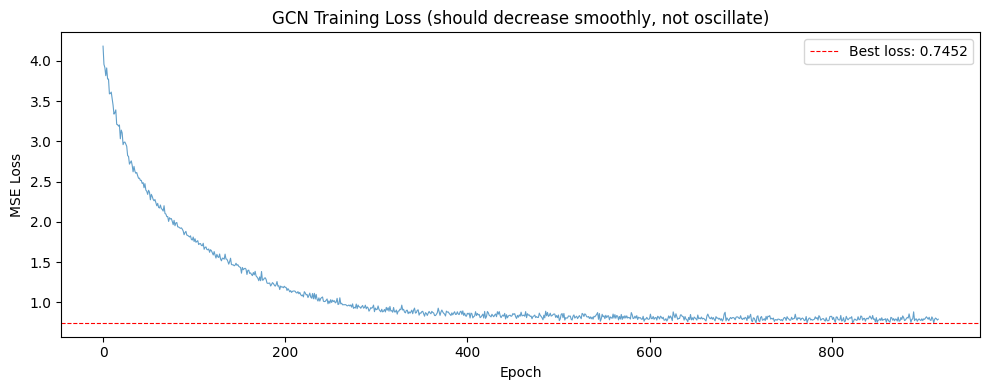


Embedding diagnostics:
  Mean std across dims: 1.2797  (should be > 0.1)
  Overall range: 7.3517
  Shape: (153, 8)
  ✓ Embeddings look healthy (no collapse detected)

Native-space metrics (L2-normed 8-D GCN embeddings):
  Silhouette: 0.2790  DBI: 1.1735  CH: 38.7

Common-space metrics (original 30-D standardized coefficients):
  Silhouette: 0.0596  DBI: 2.0838  CH: 11.4
  ⚡ Low but positive common-space silhouette → weak structure.

PCA-component space metrics (5-D PCA projections):
  Silhouette: 0.1367  DBI: 1.5370  CH: 20.8
  ⚡ Low but positive PCA-space silhouette → weak alignment with PCA structure.

[GCN embeddings + KMeans (k=7)]
Total points: 153
Number of clusters (excluding noise): 7
Cluster sizes (excluding noise): {0: 16, 1: 27, 2: 16, 3: 26, 4: 25, 5: 21, 6: 22}
Silhouette Score: 0.2789991796016693
Davies-Bouldin Index: 1.1735075956524805
Calinski-Harabasz Index: 38.65891152799047


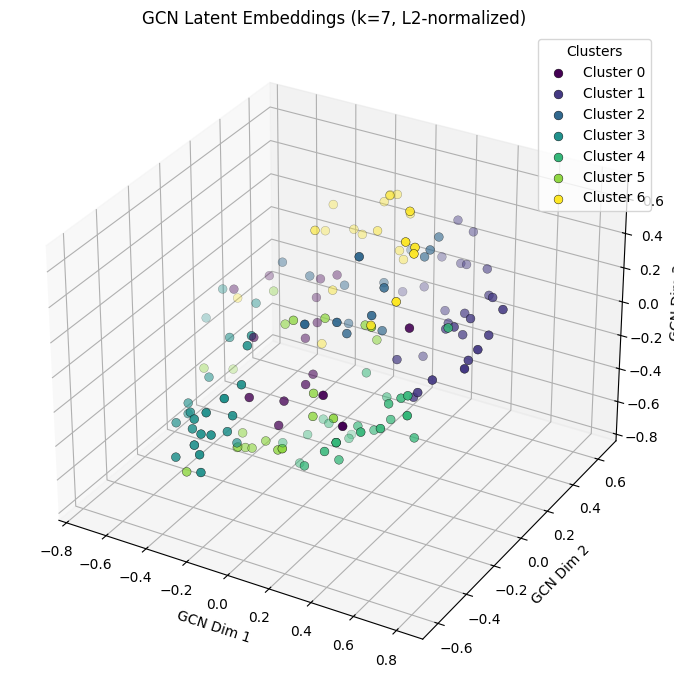

In [19]:
# ---------------------------------------------------------------------------
# Final GCN training with convergence monitoring and early stopping.
#
# KEY IMPROVEMENTS:
#   1. LEARNING RATE SCHEDULER: ReduceLROnPlateau halves the LR whenever
#      the loss stalls for 50 epochs.  This lets the model start with a
#      reasonable step size and then fine-tune.
#   2. EARLY STOPPING: If loss doesn't improve for 200 epochs, stop early.
#      The old code trained for a fixed 2000 epochs even when loss was
#      oscillating wildly — wasting time and degrading the embedding.
#   3. EVAL MODE FOR EXTRACTION: model.eval() disables dropout and uses
#      BatchNorm running statistics for the final embedding.
#   4. L2 NORMALIZATION: Same as grid search — embeddings are projected
#      to the unit hypersphere before KMeans.
#   5. COMMON-SPACE VALIDATION: Also computes silhouette on the ORIGINAL
#      30-D standardized coefficient features, so you can immediately see
#      whether GCN clusters have meaning in the actual health-indicator space.
#   6. CONVERGENCE PLOT: Shows training loss over epochs so you can
#      visually confirm the model converged (no oscillation).
# ---------------------------------------------------------------------------

import torch
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import normalize as sklearn_normalize

set_seed(42)

# Use best LR and k from grid search; architecture matches the search cell
best_lr = best_gcn_search['lr']
best_k  = best_gcn_search['n_clusters']
GCN_FINAL_EPOCHS = 3000             # max epochs (early stopping will usually trigger first)
PATIENCE = 200                       # stop if no improvement for this many epochs
LR_PATIENCE = 50                     # reduce LR if no improvement for this many epochs

print(f"Final GCN training: lr={best_lr}, arch={in_channels}→{GCN_HIDDEN}→{GCN_OUT_CHANNELS}")
print(f"Will cluster with k={best_k} (from grid search)")
print(f"Early stopping patience={PATIENCE}, LR patience={LR_PATIENCE}")

model = GCNAutoEncoder(in_channels, GCN_HIDDEN, GCN_OUT_CHANNELS)
optimizer = torch.optim.Adam(model.parameters(), lr=best_lr, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=LR_PATIENCE, verbose=False
)
loss_func = torch.nn.MSELoss()

# --- Training loop with early stopping ---
loss_history = []
best_loss = float('inf')
best_state = None
epochs_no_improve = 0

model.train()
for epoch in range(GCN_FINAL_EPOCHS):
    optimizer.zero_grad()
    output, latent = model(graph_data.x, graph_data.edge_index)
    loss = loss_func(output, graph_data.x)
    loss.backward()
    optimizer.step()

    loss_val = loss.item()
    loss_history.append(loss_val)
    scheduler.step(loss_val)

    # Track best model
    if loss_val < best_loss - 1e-5:
        best_loss = loss_val
        best_state = {k: v.clone() for k, v in model.state_dict().items()}
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1

    if epoch % 200 == 0:
        current_lr = optimizer.param_groups[0]['lr']
        print(f"  Epoch {epoch:4d}: Loss {loss_val:.6f}  LR {current_lr:.6f}  "
              f"(best={best_loss:.6f}, patience={epochs_no_improve}/{PATIENCE})")

    # Early stopping
    if epochs_no_improve >= PATIENCE:
        print(f"\n  Early stopping at epoch {epoch} (no improvement for {PATIENCE} epochs)")
        break

# Restore best model
if best_state is not None:
    model.load_state_dict(best_state)
    print(f"  Restored best model (loss={best_loss:.6f})")

# --- Plot training loss ---
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(loss_history, linewidth=0.8, alpha=0.7)
ax.set_xlabel('Epoch')
ax.set_ylabel('MSE Loss')
ax.set_title('GCN Training Loss (should decrease smoothly, not oscillate)')
ax.axhline(best_loss, color='red', linestyle='--', linewidth=0.8, label=f'Best loss: {best_loss:.4f}')
ax.legend()
plt.tight_layout()
plt.show()

# --- Extract embeddings in EVAL mode ---
model.eval()
with torch.no_grad():
    _, latent = model(graph_data.x, graph_data.edge_index)
embeddings4_raw = latent.numpy()

# Embedding health check
emb_std = embeddings4_raw.std(axis=0).mean()
emb_range = embeddings4_raw.max() - embeddings4_raw.min()
print(f"\nEmbedding diagnostics:")
print(f"  Mean std across dims: {emb_std:.4f}  (should be > 0.1)")
print(f"  Overall range: {emb_range:.4f}")
print(f"  Shape: {embeddings4_raw.shape}")

if emb_std < 0.1:
    print("  ⚠ WARNING: embeddings may be partially collapsed. Consider:")
    print("    - Increasing GCN_HIDDEN")
    print("    - Reducing GCN_OUT_CHANNELS")
    print("    - Lowering the learning rate")
else:
    print("  ✓ Embeddings look healthy (no collapse detected)")

# L2-normalize for clustering (same as grid search)
embeddings4 = sklearn_normalize(embeddings4_raw, norm='l2')

# --- Cluster ---
kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
cluster_labels4 = kmeans.fit_predict(embeddings4)

# --- Evaluate in BOTH native and common space ---
unique_labels = np.unique(cluster_labels4)
if len(unique_labels) < 2:
    print("\nOnly one cluster was found; metrics cannot be computed.")
else:
    # Native space (L2-normalized GCN embeddings)
    sil_native = silhouette_score(embeddings4, cluster_labels4)
    dbi_native = davies_bouldin_score(embeddings4, cluster_labels4)
    chi_native = calinski_harabasz_score(embeddings4, cluster_labels4)
    print(f"\nNative-space metrics (L2-normed {GCN_OUT_CHANNELS}-D GCN embeddings):")
    print(f"  Silhouette: {sil_native:.4f}  DBI: {dbi_native:.4f}  CH: {chi_native:.1f}")

    # Common space (original 30-D standardized coefficients)
    feature_cols_check = [c for c in coefficients_df_cleaned.columns
                          if c not in ('County', 'Cluster')]
    X_common = coefficients_df_cleaned[feature_cols_check].values
    sil_common = silhouette_score(X_common, cluster_labels4)
    dbi_common = davies_bouldin_score(X_common, cluster_labels4)
    chi_common = calinski_harabasz_score(X_common, cluster_labels4)
    print(f"\nCommon-space metrics (original 30-D standardized coefficients):")
    print(f"  Silhouette: {sil_common:.4f}  DBI: {dbi_common:.4f}  CH: {chi_common:.1f}")

    if sil_common < 0:
        print("  ⚠ Negative common-space silhouette → clusters may not reflect")
        print("    real structure in health-indicator space.")
    elif sil_common < 0.15:
        print("  ⚡ Low but positive common-space silhouette → weak structure.")
    else:
        print("  ✓ Positive common-space silhouette → clusters have meaning")
        print("    in the original health-indicator space.")

    # PCA-component space (the 5-D PCA features that were fed INTO the GCN)
    X_pca_space = graph_data.x.numpy()  # PCA features used as GCN input
    sil_pca = silhouette_score(X_pca_space, cluster_labels4)
    dbi_pca = davies_bouldin_score(X_pca_space, cluster_labels4)
    chi_pca = calinski_harabasz_score(X_pca_space, cluster_labels4)
    print(f"\nPCA-component space metrics ({X_pca_space.shape[1]}-D PCA projections):")
    print(f"  Silhouette: {sil_pca:.4f}  DBI: {dbi_pca:.4f}  CH: {chi_pca:.1f}")
    if sil_pca < 0:
        print("  ⚠ Negative PCA-space silhouette → GCN clusters do not align")
        print("    with PCA structure at all.")
    elif sil_pca < 0.15:
        print("  ⚡ Low but positive PCA-space silhouette → weak alignment with PCA structure.")
    else:
        print("  ✓ Positive PCA-space silhouette → GCN clusters align meaningfully")
        print("    with the principal component structure.")

summarize_clusters(cluster_labels4, embeddings4,
                   method_name=f"GCN embeddings + KMeans (k={best_k})")

# --- 3D visualization (first 3 dims of L2-normed latent space) ---
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
colors = plt.cm.viridis(np.linspace(0, 1, best_k))
for i, color in enumerate(colors):
    mask = cluster_labels4 == i
    ax.scatter(embeddings4[mask, 0], embeddings4[mask, 1], embeddings4[mask, 2],
               c=[color], label=f'Cluster {i}', s=40, edgecolors='k', linewidth=0.3)
ax.set_xlabel('GCN Dim 1')
ax.set_ylabel('GCN Dim 2')
ax.set_zlabel('GCN Dim 3')
ax.set_title(f'GCN Latent Embeddings (k={best_k}, L2-normalized)')
ax.legend(title="Clusters")
plt.tight_layout()
plt.show()


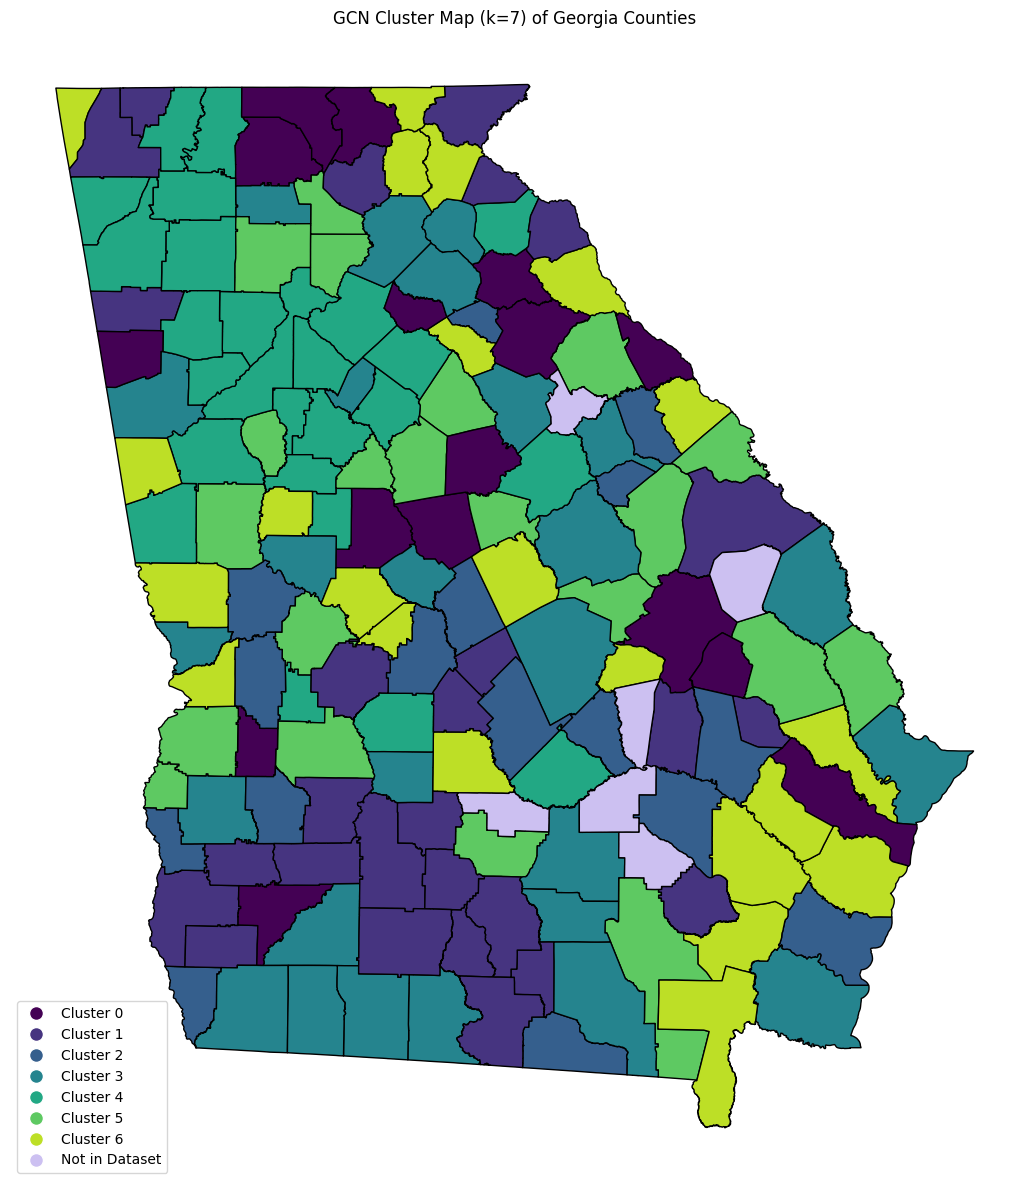

In [20]:
# Georgia map for GCN clusters — uses the reusable helper
plot_ga_cluster_map(
    cluster_labels4,
    coefficients_df_cleaned['County'].values,
    title=f'GCN Cluster Map (k={best_k}) of Georgia Counties',
)


CLUSTER STABILITY ANALYSIS

--- PCA Space (k=3) ---
Bootstrap stability (N=200, 80% subsample):
  ARI = 0.618 ± 0.152
Seed sweep (20 seeds):
  ARI vs reference = 0.761 ± 0.105
  Silhouette = 0.1546 ± 0.0030

--- GCN Embeddings (k=7) ---
Bootstrap stability (N=200, 80% subsample):
  ARI = 0.681 ± 0.124
Seed sweep (20 seeds):
  ARI vs reference = 0.770 ± 0.107
  Silhouette = 0.2749 ± 0.0040

--- Sensitivity to k (bootstrap ARI for neighboring k values) ---
  This checks whether the chosen k is notably more stable than k±1.
  If neighboring k values are equally stable, the choice is less
  definitive — but if the chosen k is clearly the best, that's strong
  evidence.

  PCA space (chosen k=3):
    k=2: bootstrap ARI=0.701±0.266, seed ARI=0.933±0.044, silhouette=0.1617±0.0023
    k=3: bootstrap ARI=0.619±0.143, seed ARI=0.758±0.134, silhouette=0.1539±0.0028 ← chosen
    k=4: bootstrap ARI=0.547±0.158, seed ARI=0.579±0.163, silhouette=0.1535±0.0104
  GCN space (chosen k=7):
    k=6: bootst

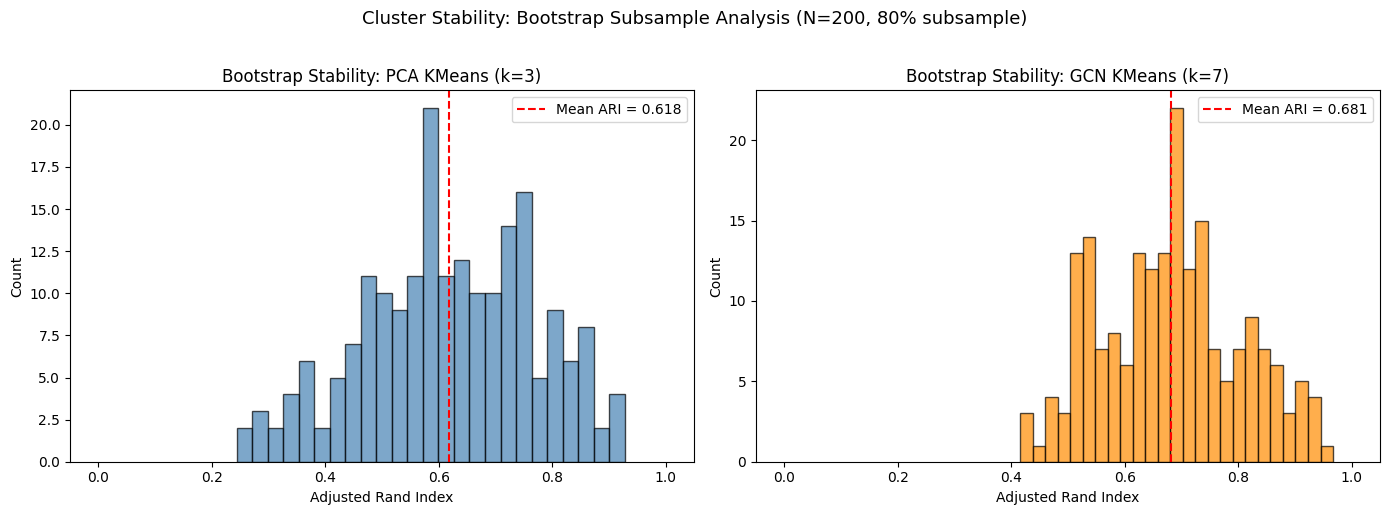


INTERPRETATION GUIDE
• ARI > 0.80: Highly stable — clusters are robust to perturbation.
• ARI 0.60–0.80: Moderately stable — clusters capture real structure
  but some boundary points shift between clusters.
• ARI < 0.60: Unstable — cluster assignments change substantially
  with different subsets or seeds. Interpret with caution.
• If silhouette std > 0.05 across seeds, the metric itself is unreliable.
• In a paper, report: 'Bootstrap stability ARI = X.XX ± Y.YY (N=200,
  80% subsample); seed sweep ARI = X.XX ± Y.YY (20 seeds).'


In [21]:
# ==========================================================================
# Cluster Stability Analysis
#
# Purpose: Validate that the chosen k values produce stable, reproducible
# clusters — not artifacts of sample composition or random initialization.
#
# Two complementary tests are run for each (space, k) combination:
#
# 1. BOOTSTRAP STABILITY (N=200 resamples):
#    - Resample 80% of counties without replacement.
#    - Re-cluster the subsample with the same k.
#    - Measure Adjusted Rand Index (ARI) between the subsample cluster
#      assignments and the full-dataset assignments for those same counties.
#    - ARI is a standard measure of how "similar" two clusterings are,
#      corrected for chance.  It ranges from ~0 (random agreement) to 1
#      (perfect match).  Values > 0.6 indicate reasonable stability;
#      values > 0.8 indicate very strong stability.
#
# 2. SEED SWEEP (20 seeds):
#    - Rerun KMeans with different random seeds on the full dataset.
#    - Measure ARI between each seed's result and the reference (seed=42).
#    - Also track how silhouette varies across seeds.
#    - High ARI means the result doesn't depend on KMeans initialization.
#
# 3. SENSITIVITY TO k (k ± 1):
#    - Repeat both tests for neighboring k values to show the chosen k
#      is not arbitrarily fragile — a reviewer might ask "why not k-1?"
#
# Together these answer: "Are these clusters real structure, or noise?"
# ==========================================================================

import numpy as np
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import adjusted_rand_score, silhouette_score
import matplotlib.pyplot as plt


def bootstrap_stability(X, k, n_bootstraps=200, subsample_frac=0.80,
                        reference_seed=42, bootstrap_seed=0):
    """
    Subsample stability analysis for KMeans clustering.

    How it works:
      1. Run KMeans(k) on the FULL dataset to get a "reference" labeling.
      2. For each of 200 bootstrap iterations, draw a random 80% subsample
         of the data (without replacement) and re-cluster it.
      3. For the counties that appear in the subsample, compare the new
         labels to what the reference gave those same counties, using
         Adjusted Rand Index (ARI).

    ARI corrects for chance: two random clusterings score ~0, identical
    clusterings score 1.  A high mean ARI (> 0.6) means the clusters
    survive when you remove 20% of the data — i.e., no single subset of
    counties is holding the clusters together.
    """
    rng = np.random.RandomState(bootstrap_seed)
    n = len(X)
    n_sub = int(n * subsample_frac)

    # Reference clustering on the full dataset
    ref_labels = KMeans(n_clusters=k, random_state=reference_seed,
                        n_init=10).fit_predict(X)

    ari_scores = []
    for _ in range(n_bootstraps):
        idx = rng.choice(n, size=n_sub, replace=False)
        X_sub = X[idx]
        sub_labels = KMeans(n_clusters=k, random_state=reference_seed,
                            n_init=10).fit_predict(X_sub)
        ari = adjusted_rand_score(ref_labels[idx], sub_labels)
        ari_scores.append(ari)

    return np.mean(ari_scores), np.std(ari_scores), ari_scores


def seed_sweep(X, k, n_seeds=20, reference_seed=42):
    """
    Test sensitivity to KMeans random initialization.

    How it works:
      1. Run KMeans once with seed=42 as the "reference."
      2. Rerun KMeans with 20 different seeds and compare each to the
         reference using ARI.
      3. Also record the silhouette score for each seed.

    If ARI is consistently high (> 0.9) and silhouette barely changes,
    then KMeans initialization doesn't matter — the clusters are well-defined.
    """
    ref_labels = KMeans(n_clusters=k, random_state=reference_seed,
                        n_init=10).fit_predict(X)
    ref_sil = silhouette_score(X, ref_labels)

    ari_scores = []
    sil_scores = [ref_sil]
    for seed in range(n_seeds):
        labels = KMeans(n_clusters=k, random_state=seed,
                        n_init=10).fit_predict(X)
        ari_scores.append(adjusted_rand_score(ref_labels, labels))
        sil_scores.append(silhouette_score(X, labels))

    return {
        'ari_mean': np.mean(ari_scores),
        'ari_std': np.std(ari_scores),
        'ari_scores': ari_scores,
        'sil_mean': np.mean(sil_scores),
        'sil_std': np.std(sil_scores),
        'sil_scores': sil_scores,
    }


# ---- Build data representations (same as clustering cells above) ----------
feature_cols_stab = [c for c in coefficients_df_cleaned.columns
                     if c not in ('County', 'Cluster')]
X_raw_stab = coefficients_df_cleaned[feature_cols_stab].values

pca_stab = PCA(n_components=PCA_COMPONENTS)
X_pca_stab = pca_stab.fit_transform(X_raw_stab)

X_gcn_stab = embeddings4  # GCN latent embeddings from Cell 22

# The k values selected by earlier grid searches
k_pca = kmeans_k   # from Cell 11
k_gcn = best_k     # from Cell 22

print("=" * 70)
print("CLUSTER STABILITY ANALYSIS")
print("=" * 70)

# ---- PCA Space -----------------------------------------------------------
print(f"\n--- PCA Space (k={k_pca}) ---")

boot_mean_pca, boot_std_pca, boot_aris_pca = bootstrap_stability(
    X_pca_stab, k_pca)
print(f"Bootstrap stability (N=200, 80% subsample):")
print(f"  ARI = {boot_mean_pca:.3f} ± {boot_std_pca:.3f}")

seed_results_pca = seed_sweep(X_pca_stab, k_pca)
print(f"Seed sweep (20 seeds):")
print(f"  ARI vs reference = {seed_results_pca['ari_mean']:.3f} "
      f"± {seed_results_pca['ari_std']:.3f}")
print(f"  Silhouette = {seed_results_pca['sil_mean']:.4f} "
      f"± {seed_results_pca['sil_std']:.4f}")

# ---- GCN Embeddings ------------------------------------------------------
print(f"\n--- GCN Embeddings (k={k_gcn}) ---")

boot_mean_gcn, boot_std_gcn, boot_aris_gcn = bootstrap_stability(
    X_gcn_stab, k_gcn)
print(f"Bootstrap stability (N=200, 80% subsample):")
print(f"  ARI = {boot_mean_gcn:.3f} ± {boot_std_gcn:.3f}")

seed_results_gcn = seed_sweep(X_gcn_stab, k_gcn)
print(f"Seed sweep (20 seeds):")
print(f"  ARI vs reference = {seed_results_gcn['ari_mean']:.3f} "
      f"± {seed_results_gcn['ari_std']:.3f}")
print(f"  Silhouette = {seed_results_gcn['sil_mean']:.4f} "
      f"± {seed_results_gcn['sil_std']:.4f}")

# ---- Sensitivity to k (k ± 1) -------------------------------------------
print(f"\n--- Sensitivity to k (bootstrap ARI for neighboring k values) ---")
print("  This checks whether the chosen k is notably more stable than k±1.")
print("  If neighboring k values are equally stable, the choice is less")
print("  definitive — but if the chosen k is clearly the best, that's strong")
print("  evidence.\n")

for space_name, X_space, chosen_k in [("PCA", X_pca_stab, k_pca),
                                       ("GCN", X_gcn_stab, k_gcn)]:
    print(f"  {space_name} space (chosen k={chosen_k}):")
    for test_k in range(max(2, chosen_k - 1), chosen_k + 2):
        bm, bs, _ = bootstrap_stability(X_space, test_k, n_bootstraps=100)
        ss = seed_sweep(X_space, test_k, n_seeds=10)
        marker = " ← chosen" if test_k == chosen_k else ""
        print(f"    k={test_k}: bootstrap ARI={bm:.3f}±{bs:.3f}, "
              f"seed ARI={ss['ari_mean']:.3f}±{ss['ari_std']:.3f}, "
              f"silhouette={ss['sil_mean']:.4f}±{ss['sil_std']:.4f}{marker}")

# ---- Visualization -------------------------------------------------------
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(boot_aris_pca, bins=25, alpha=0.7, color='steelblue',
             edgecolor='black')
axes[0].axvline(np.mean(boot_aris_pca), color='red', linestyle='--',
                label=f'Mean ARI = {np.mean(boot_aris_pca):.3f}')
axes[0].set_title(f'Bootstrap Stability: PCA KMeans (k={k_pca})')
axes[0].set_xlabel('Adjusted Rand Index')
axes[0].set_ylabel('Count')
axes[0].set_xlim(-0.05, 1.05)
axes[0].legend()

axes[1].hist(boot_aris_gcn, bins=25, alpha=0.7, color='darkorange',
             edgecolor='black')
axes[1].axvline(np.mean(boot_aris_gcn), color='red', linestyle='--',
                label=f'Mean ARI = {np.mean(boot_aris_gcn):.3f}')
axes[1].set_title(f'Bootstrap Stability: GCN KMeans (k={k_gcn})')
axes[1].set_xlabel('Adjusted Rand Index')
axes[1].set_ylabel('Count')
axes[1].set_xlim(-0.05, 1.05)
axes[1].legend()

plt.suptitle('Cluster Stability: Bootstrap Subsample Analysis '
             '(N=200, 80% subsample)',
             fontsize=13, y=1.02)
plt.tight_layout()
plt.show()

# ---- Interpretation guide -------------------------------------------------
print("\n" + "=" * 70)
print("INTERPRETATION GUIDE")
print("=" * 70)
print("• ARI > 0.80: Highly stable — clusters are robust to perturbation.")
print("• ARI 0.60–0.80: Moderately stable — clusters capture real structure")
print("  but some boundary points shift between clusters.")
print("• ARI < 0.60: Unstable — cluster assignments change substantially")
print("  with different subsets or seeds. Interpret with caution.")
print("• If silhouette std > 0.05 across seeds, the metric itself is unreliable.")
print("• In a paper, report: 'Bootstrap stability ARI = X.XX ± Y.YY (N=200,")
print("  80% subsample); seed sweep ARI = X.XX ± Y.YY (20 seeds).'")



In [22]:
from scipy.stats import f_oneway
from statsmodels.stats.multitest import multipletests
import pandas as pd

# Use GCN clusters for post-clustering statistical analysis.
# .copy() avoids SettingWithCopyWarning from earlier slicing.
coefficients_df_cleaned = coefficients_df_cleaned.copy()
coefficients_df_cleaned['Cluster'] = cluster_labels4

# Exclude 'Cluster' and 'County' from the features list
features = coefficients_df_cleaned.columns.drop(['Cluster', 'County'])

# Initialize an empty list to hold the results
anova_results_list = []

# Guard: ANOVA needs at least 2 clusters
unique_clusters = coefficients_df_cleaned['Cluster'].unique()
if len(unique_clusters) < 2:
    print("ANOVA skipped: only one cluster was found, need at least 2 clusters.")
else:
    # Loop through each feature and perform ANOVA
    for feature in features:
        # Get the groups based on clusters
        groups = [
            coefficients_df_cleaned[coefficients_df_cleaned['Cluster'] == cluster][feature]
            for cluster in unique_clusters
        ]
        # Perform ANOVA
        f_statistic, p_value = f_oneway(*groups)

        # Append results — we will add corrected columns AFTER the loop
        anova_results_list.append({
            'Feature': feature,
            'F-Statistic': f_statistic,
            'p-value (raw)': p_value,
        })

    # Create a DataFrame from the results list
    anova_results_df = pd.DataFrame(anova_results_list)

    # -------------------------------------------------------------------
    # FDR correction (Benjamini-Hochberg)
    #
    # WHY THIS MATTERS:
    # We are testing 30 features simultaneously. At α=0.05 without any
    # correction, we would expect ~1.5 false positives purely by chance
    # (30 × 0.05 = 1.5). Some features with raw p ≈ 0.03 may not be
    # genuinely significant — they just got lucky.
    #
    # HOW IT WORKS:
    # The Benjamini-Hochberg (BH) procedure controls the False Discovery
    # Rate (FDR): the expected *proportion* of false positives among all
    # rejected hypotheses. It works by:
    #   1. Sorting all p-values from smallest to largest.
    #   2. Comparing each p-value to a progressively stricter threshold:
    #      (rank / total_tests) × α.
    #   3. The largest p-value that still passes its threshold, and
    #      everything below it, is declared significant.
    #
    # The result is a set of "adjusted p-values" — if an adjusted p-value
    # is < 0.05, it means that feature is significant even after
    # accounting for the fact that we tested many features at once.
    #
    # This is standard practice in academic publications and is less
    # conservative than Bonferroni (which controls the family-wise error
    # rate and can be too strict, especially with correlated tests).
    # -------------------------------------------------------------------
    raw_pvals = anova_results_df['p-value (raw)'].values
    reject_fdr, pvals_fdr, _, _ = multipletests(raw_pvals, alpha=0.05,
                                                 method='fdr_bh')

    anova_results_df['p-value (FDR)'] = pvals_fdr
    anova_results_df['Reject Null (raw)'] = raw_pvals < 0.05
    anova_results_df['Reject Null (FDR)'] = reject_fdr

    # Print the DataFrame
    print(anova_results_df)

    # Summary counts
    n_raw = int(anova_results_df['Reject Null (raw)'].sum())
    n_fdr = int(anova_results_df['Reject Null (FDR)'].sum())
    print(f"\nFeatures significant at raw α=0.05: {n_raw} / {len(anova_results_df)}")
    print(f"Features significant after FDR correction: {n_fdr} / {len(anova_results_df)}")

    if n_raw > n_fdr:
        lost = n_raw - n_fdr
        print(f"⚠ {lost} feature(s) lost significance after FDR correction — "
              f"their raw p-values were borderline and should NOT be cited "
              f"as significant in a paper.")

    # Save the results to a CSV file (with both raw and corrected columns)
    anova_results_df.to_csv('./anova_results.csv', index=False)


                                           Feature  F-Statistic  \
0                        Pct_Children_in_Poverty_a     4.013294   
1                        Pct_Children_in_Poverty_b     4.012351   
2                        Pct_Children_in_Poverty_c     4.011301   
3                         Pct_Excessive_Drinking_a    12.770490   
4                         Pct_Excessive_Drinking_b    12.768705   
5                         Pct_Excessive_Drinking_c    12.766847   
6                                    Pct_Smokers_a     8.951736   
7                                    Pct_Smokers_b     8.951882   
8                                    Pct_Smokers_c     8.951993   
9                                 Pct_Unemployed_a    12.460796   
10                                Pct_Unemployed_b    12.453814   
11                                Pct_Unemployed_c    12.446767   
12                                 Pct_Uninsured_a    11.700751   
13                                 Pct_Uninsured_b    11.70050

In [23]:
from tabulate import tabulate

# Convert your ANOVA results DataFrame into a pretty-printed table.
# We display both the raw and FDR-corrected p-values so the reader can see
# which features survived correction.  The 'Reject Null (FDR)' column is the
# one that should be cited in a paper.
pretty_table = tabulate(anova_results_df, headers='keys', tablefmt='pretty',
                        showindex=False)

# Print the table
print(pretty_table)


+------------------------------------------------+--------------------+------------------------+------------------------+-------------------+-------------------+
|                    Feature                     |    F-Statistic     |     p-value (raw)      |     p-value (FDR)      | Reject Null (raw) | Reject Null (FDR) |
+------------------------------------------------+--------------------+------------------------+------------------------+-------------------+-------------------+
|           Pct_Children_in_Poverty_a            | 4.013293873292136  |  0.000946667525731942  | 0.0009508033840437358  |       True        |       True        |
|           Pct_Children_in_Poverty_b            | 4.0123510302689045 | 0.0009486222500231056  | 0.0009508033840437358  |       True        |       True        |
|           Pct_Children_in_Poverty_c            | 4.011301266027803  | 0.0009508033840437358  | 0.0009508033840437358  |       True        |       True        |
|            Pct_Excessive_D

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

# -------------------------------------------------------------------
# Filter for significant features using the FDR-CORRECTED decision.
#
# WHY 'Reject Null (FDR)' instead of 'Reject Null (raw)':
# Using the raw column would include features that are only "significant"
# because we tested 30 hypotheses.  After Benjamini-Hochberg correction,
# only the features that survive the stricter threshold remain.  These
# are the ones that are defensible to cite in a publication.
#
# If any features you expected to see are missing, it means their raw
# p-value was borderline and did not survive correction — they should
# be discussed cautiously (e.g., "trending but not significant after
# FDR correction").
# -------------------------------------------------------------------
significant_features = anova_results_df[
    anova_results_df['Reject Null (FDR)']
]['Feature'].tolist()

print(f"Significant features after FDR correction ({len(significant_features)}):")
for f in significant_features:
    print(f"  • {f}")

# Create a DataFrame that includes the cluster labels and the significant features
df_significant = coefficients_df_cleaned[['Cluster'] + significant_features]



Significant features after FDR correction (30):
  • Pct_Children_in_Poverty_a
  • Pct_Children_in_Poverty_b
  • Pct_Children_in_Poverty_c
  • Pct_Excessive_Drinking_a
  • Pct_Excessive_Drinking_b
  • Pct_Excessive_Drinking_c
  • Pct_Smokers_a
  • Pct_Smokers_b
  • Pct_Smokers_c
  • Pct_Unemployed_a
  • Pct_Unemployed_b
  • Pct_Unemployed_c
  • Pct_Uninsured_a
  • Pct_Uninsured_b
  • Pct_Uninsured_c
  • ER_Visit_Rate-All_Other_Unintentional_Injury_a
  • ER_Visit_Rate-All_Other_Unintentional_Injury_b
  • ER_Visit_Rate-All_Other_Unintentional_Injury_c
  • ER_Visit_Rate-Falls_a
  • ER_Visit_Rate-Falls_b
  • ER_Visit_Rate-Falls_c
  • Injury_Death_Rate_a
  • Injury_Death_Rate_b
  • Injury_Death_Rate_c
  • Teen_Birth_Rate_a
  • Teen_Birth_Rate_b
  • Teen_Birth_Rate_c
  • Violent_Crime_Rate_a
  • Violent_Crime_Rate_b
  • Violent_Crime_Rate_c


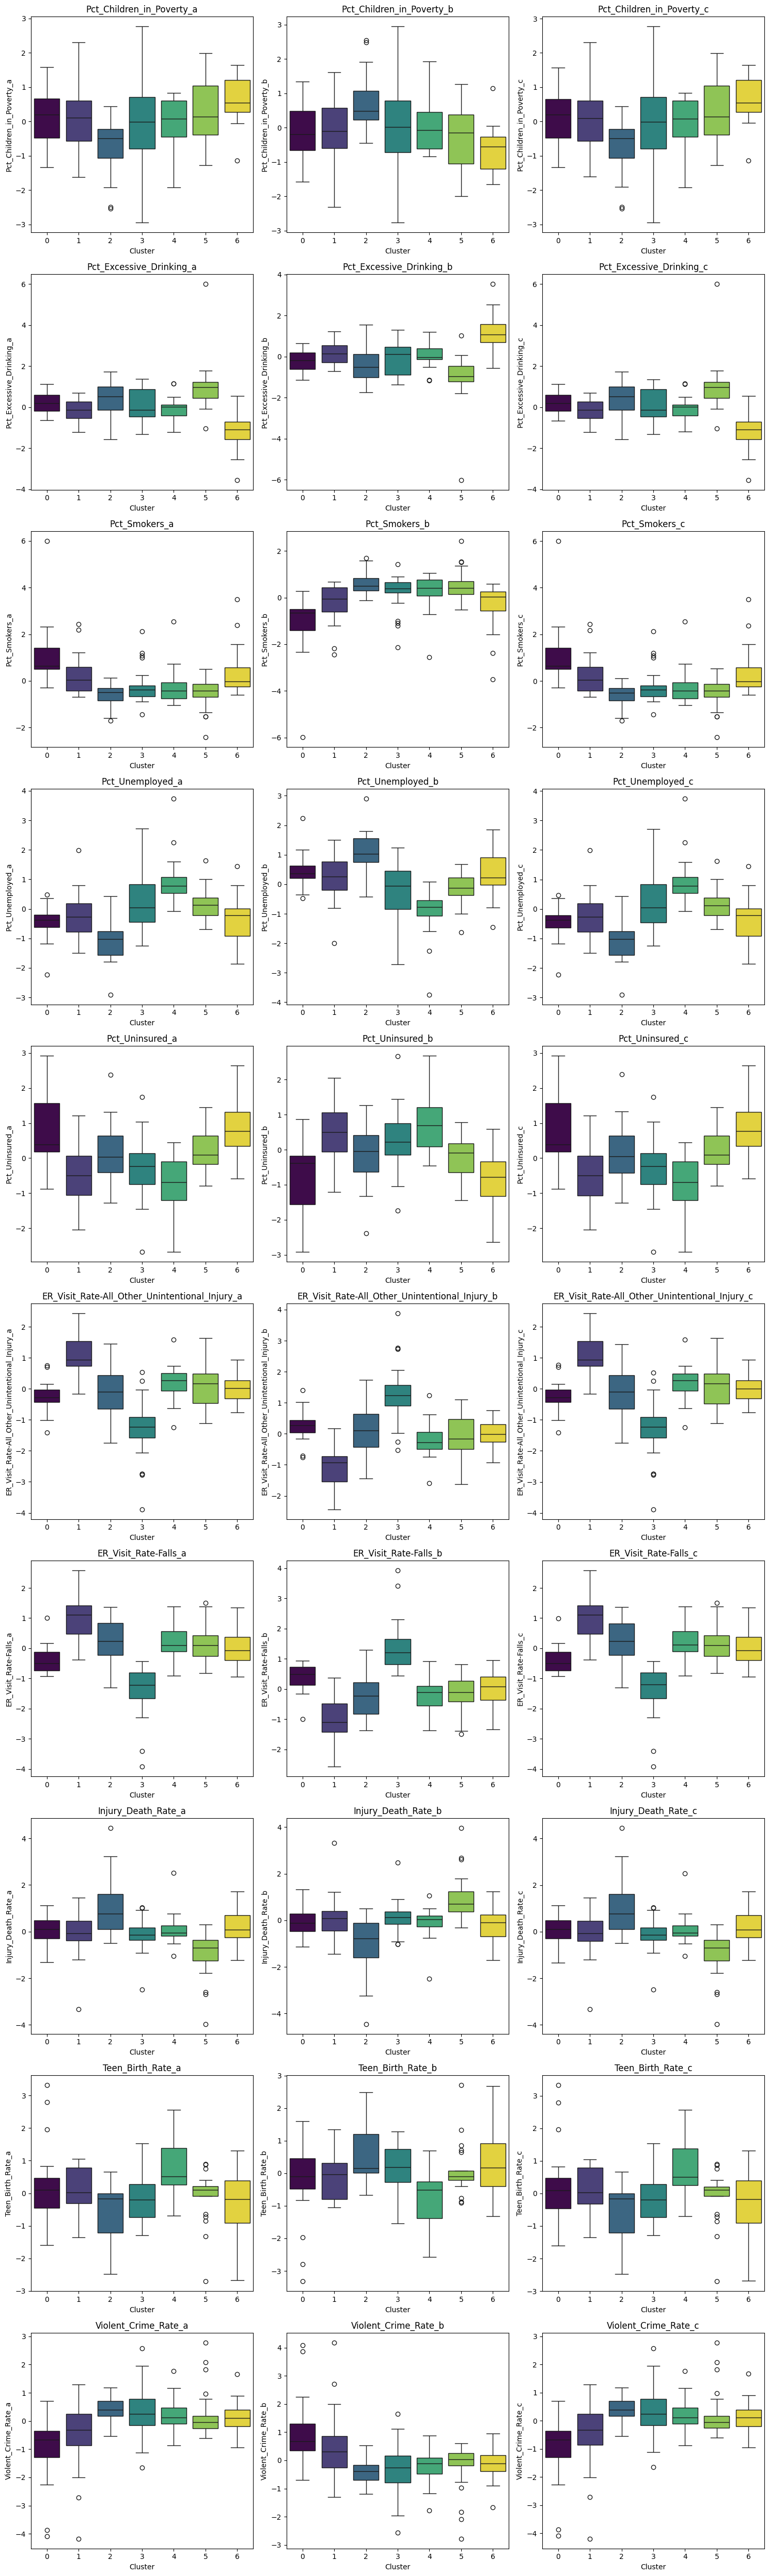

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'significant_features' and cluster labels are defined
num_features = len(significant_features)
num_columns = 3  # Number of columns in the grid
num_rows = (num_features + num_columns - 1) // num_columns  # Calculate rows needed, rounding up

# Determine the number of unique clusters
unique_clusters = np.unique(coefficients_df_cleaned['Cluster'])

# Create a color palette from a colormap and convert it to list
colors = plt.cm.viridis(np.linspace(0, 1, len(unique_clusters))).tolist()

# Create a large figure to hold the subplots
plt.figure(figsize=(15, 5 * num_rows))

# Iterate over the significant features to create a subplot for each
for i, feature in enumerate(significant_features, 1):
    plt.subplot(num_rows, num_columns, i)
    sns.boxplot(x='Cluster', y=feature, data=coefficients_df_cleaned, hue='Cluster', palette=colors, dodge=False, legend=False)
    plt.title(feature)
    plt.legend([],[], frameon=False)  # Disable the legend
    plt.tight_layout()

plt.show()


In [26]:
import pandas as pd
import numpy as np
from scipy.stats import ttest_1samp

# Assuming 'coefficients_df_cleaned' is your DataFrame and 'significant_features' lists the features of interest
clusters = coefficients_df_cleaned['Cluster'].unique()
overall_means = coefficients_df_cleaned[significant_features].mean()

cluster_descriptions = {}

for cluster in sorted(clusters):
    cluster_data = coefficients_df_cleaned[coefficients_df_cleaned['Cluster'] == cluster]
    cluster_means = cluster_data[significant_features].mean()
    
    # Initialize lists to store high and low significant features
    significant_high = []
    significant_low = []
    
    # Perform t-tests and determine significance
    for feature in significant_features:
        stat, p_value = ttest_1samp(cluster_data[feature], overall_means[feature])
        
        # Consider the feature significant if p-value < 0.05
        if p_value < 0.05:
            if cluster_means[feature] > overall_means[feature]:
                significant_high.append(feature)
            elif cluster_means[feature] < overall_means[feature]:
                significant_low.append(feature)
    
    # Forming the profile description
    description = f"Cluster {cluster} characteristics:\n"
    if significant_high:
        description += f"Significantly higher in: {', '.join(significant_high)}\n"
    if significant_low:
        description += f"Significantly lower in: {', '.join(significant_low)}\n"
    
    cluster_descriptions[cluster] = description

# Print all cluster descriptions
for cluster, description in cluster_descriptions.items():
    print(description)


Cluster 0 characteristics:
Significantly higher in: Pct_Smokers_a, Pct_Smokers_c, Pct_Unemployed_b, Pct_Uninsured_a, Pct_Uninsured_c, ER_Visit_Rate-Falls_b, Violent_Crime_Rate_b
Significantly lower in: Pct_Smokers_b, Pct_Unemployed_a, Pct_Unemployed_c, Pct_Uninsured_b, ER_Visit_Rate-Falls_a, ER_Visit_Rate-Falls_c, Violent_Crime_Rate_a, Violent_Crime_Rate_c

Cluster 1 characteristics:
Significantly higher in: Pct_Uninsured_b, ER_Visit_Rate-All_Other_Unintentional_Injury_a, ER_Visit_Rate-All_Other_Unintentional_Injury_c, ER_Visit_Rate-Falls_a, ER_Visit_Rate-Falls_c, Violent_Crime_Rate_b
Significantly lower in: Pct_Uninsured_a, Pct_Uninsured_c, ER_Visit_Rate-All_Other_Unintentional_Injury_b, ER_Visit_Rate-Falls_b, Violent_Crime_Rate_a, Violent_Crime_Rate_c

Cluster 2 characteristics:
Significantly higher in: Pct_Children_in_Poverty_b, Pct_Smokers_b, Pct_Unemployed_b, Injury_Death_Rate_a, Injury_Death_Rate_c, Teen_Birth_Rate_b, Violent_Crime_Rate_a, Violent_Crime_Rate_c
Significantly lower

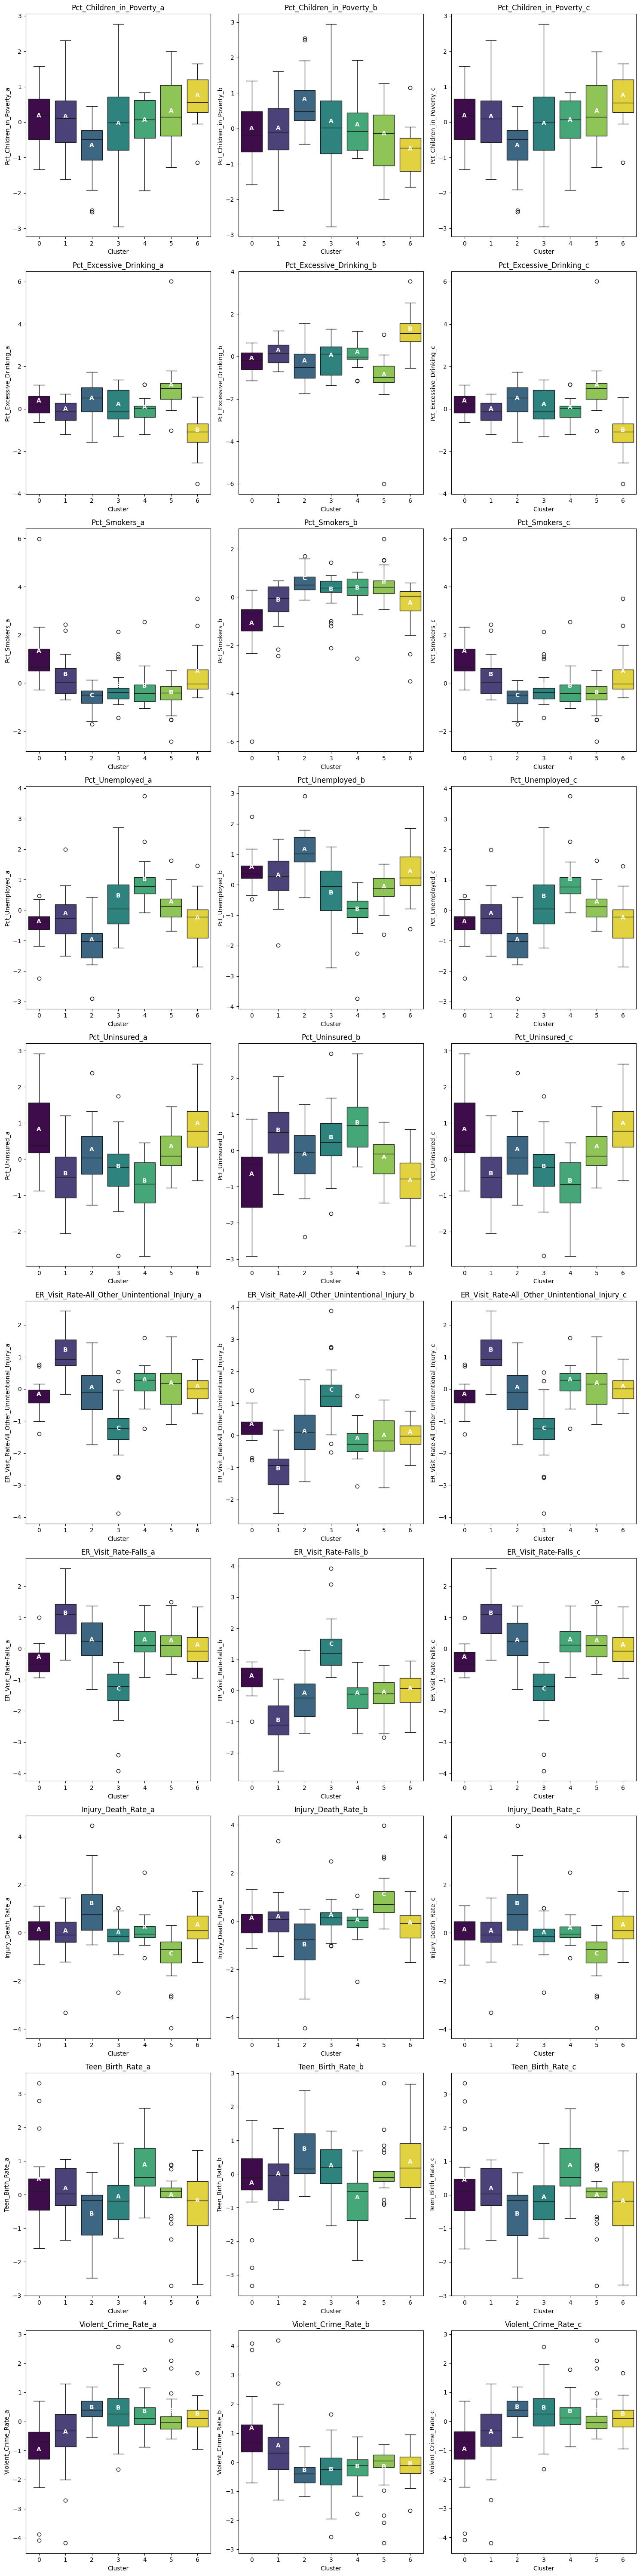

In [27]:
import pandas as pd
import numpy as np
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'coefficients_df_cleaned' and 'significant_features' are already defined

# Dictionary to store post-hoc results and group letters
post_hoc_results = {}
group_letters = {}

# Creating a color map for the clusters
unique_clusters = np.unique(coefficients_df_cleaned['Cluster'])
colors = plt.cm.viridis(np.linspace(0, 1, len(unique_clusters))).tolist()  # Convert to list for compatibility

for feature in significant_features:
    # Prepare the data for Tukey's test
    tukey_data = coefficients_df_cleaned[[feature, 'Cluster']].dropna()
    tukey_result = pairwise_tukeyhsd(endog=tukey_data[feature], groups=tukey_data['Cluster'], alpha=0.05)
    post_hoc_results[feature] = tukey_result

    # Parse the summary data to DataFrame
    summary_data = pd.DataFrame(tukey_result.summary().data[1:], columns=tukey_result.summary().data[0])
    summary_data['reject'] = summary_data['reject'].astype(bool)

    # Group clusters based on non-significant results
    clusters = tukey_result.groupsunique
    connections = {cluster: set() for cluster in clusters}
    
    for _, row in summary_data.iterrows():
        if not row['reject']:
            connections[row['group1']].add(row['group2'])
            connections[row['group2']].add(row['group1'])

    group_dict = {}
    current_group = 'A'
    for cluster in clusters:
        if cluster not in group_dict:
            groups_to_assign = [cluster] + list(connections[cluster])
            for grp in groups_to_assign:
                if grp not in group_dict:
                    group_dict[grp] = current_group
            current_group = chr(ord(current_group) + 1)

    group_letters[feature] = group_dict

num_features = len(significant_features)
num_columns = 3
num_rows = (num_features + num_columns - 1) // num_columns

plt.figure(figsize=(15, 6 * num_rows))

for i, feature in enumerate(significant_features, 1):
    plt.subplot(num_rows, num_columns, i)
    sns.boxplot(x='Cluster', y=feature, data=coefficients_df_cleaned, hue='Cluster', palette=colors, dodge=False)
    plt.legend([],[], frameon=False)
    plt.title(feature)

    # Adjust text positioning
    means = coefficients_df_cleaned.groupby('Cluster')[feature].mean()
    for cluster in clusters:
        x_pos = list(clusters).index(cluster)
        plt.text(x_pos, means[cluster], group_letters[feature].get(cluster, ''), color='white', weight='bold', ha='center', va='bottom')

    plt.tight_layout()  # Adjust layout to make room for title and axis labels

plt.show()


/var/folders/dr/13q6jns56rldkk1nfqpc25240000gn/T/ipykernel_15137/3701998140.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cluster_color_map = {cluster: plt.cm.get_cmap('viridis', len(clusters))(i) for i, cluster in enumerate(sorted(clusters))}


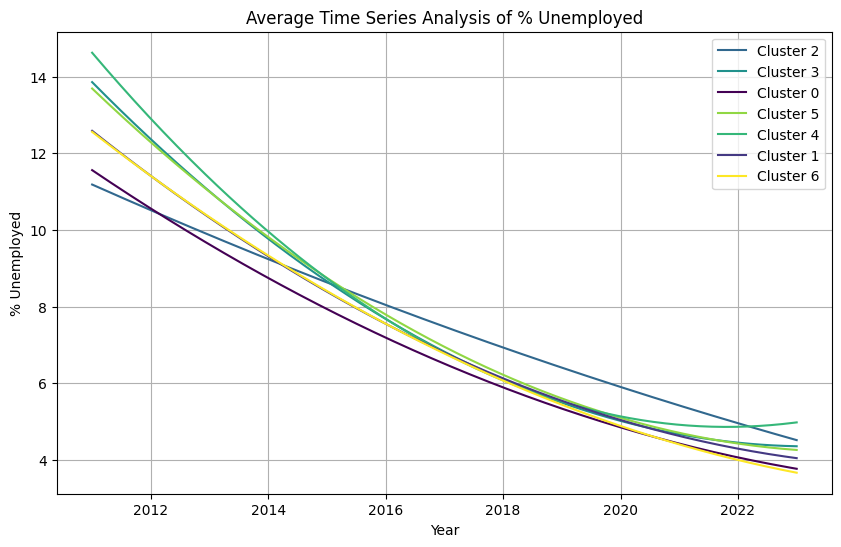

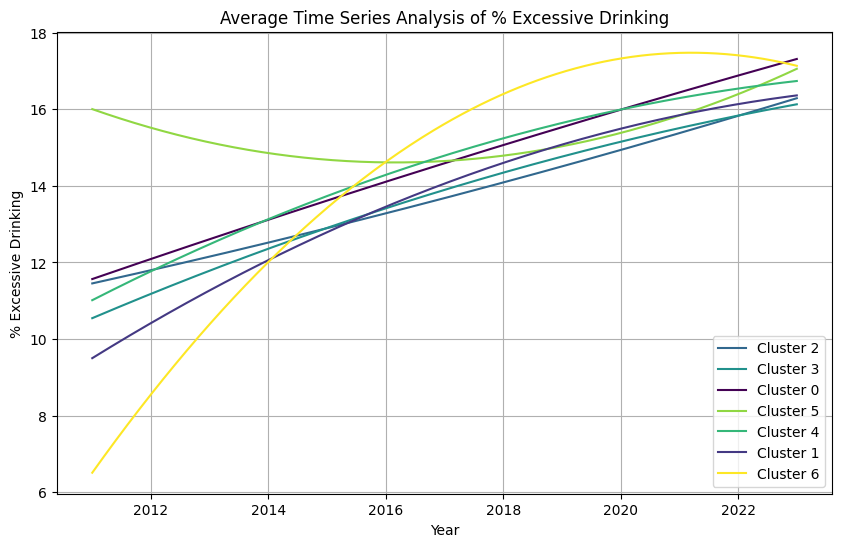

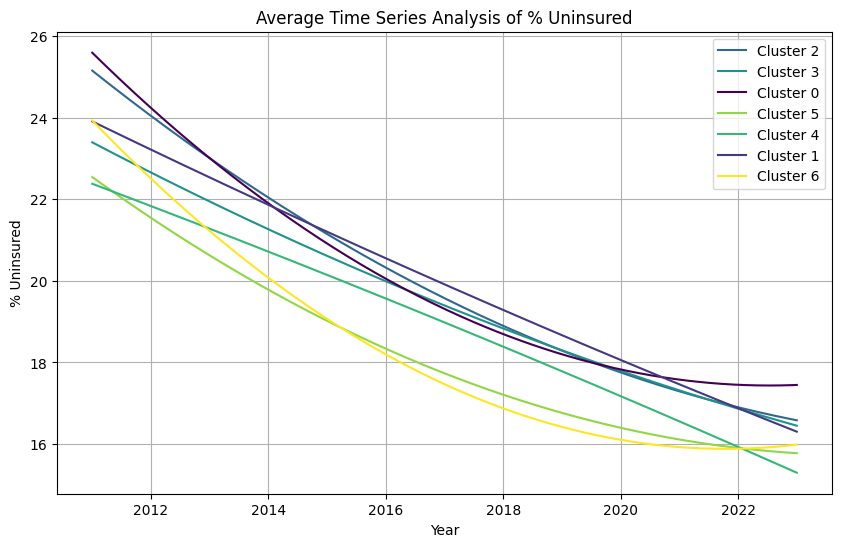

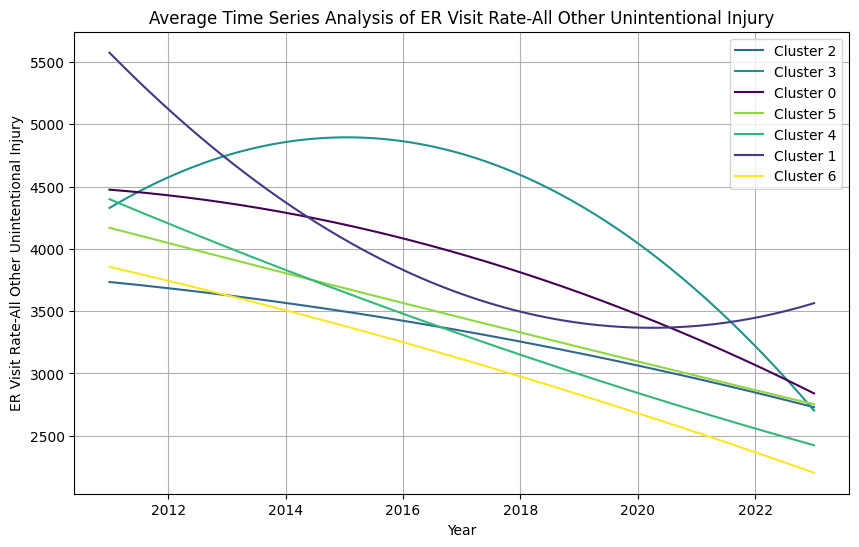

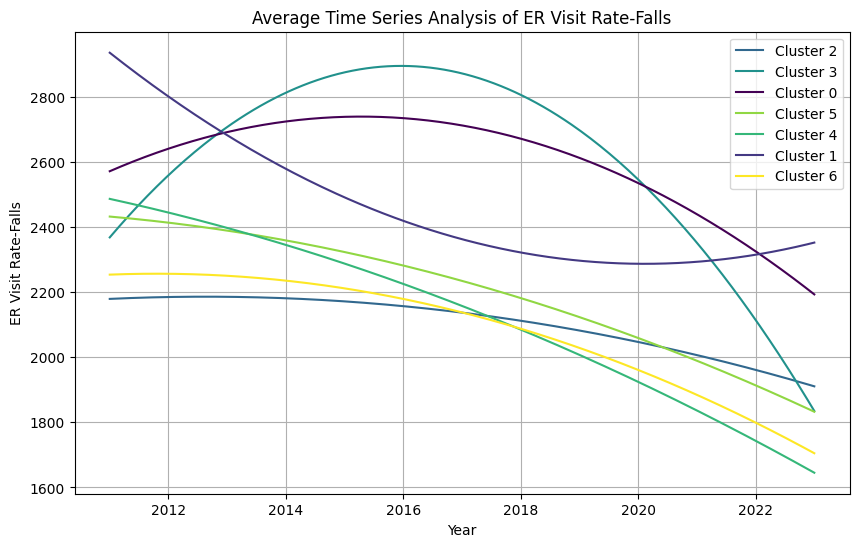

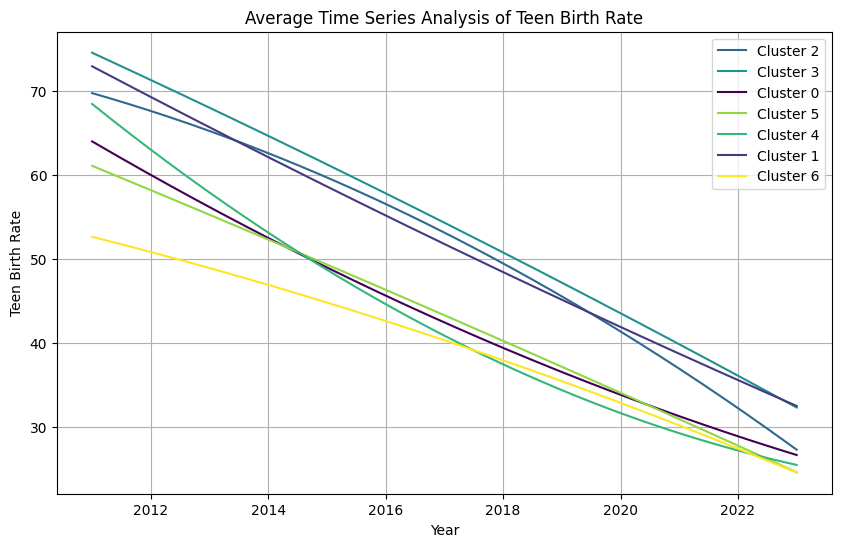

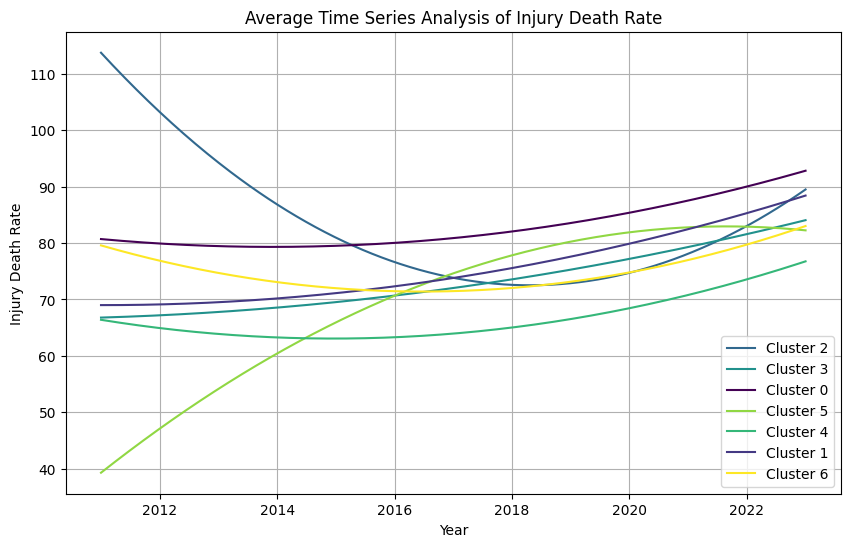

In [28]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

# Load the county data for year-wise analysis
cleaned_data_table = pd.read_csv("pivot_wide_format_data_imputed_timeseries.csv")
filtered_data_table = cleaned_data_table.loc[:, cleaned_data_table.isna().mean() < 0.3].copy()
filtered_data_table = filtered_data_table.merge(coefficients_df_cleaned[['County', 'Cluster']], on='County', how='left')


# Define the color map for clusters
clusters = coefficients_df_cleaned['Cluster'].unique()
cluster_color_map = {cluster: plt.cm.get_cmap('viridis', len(clusters))(i) for i, cluster in enumerate(sorted(clusters))}

def plot_average_by_cluster(data, feature_name):
    plt.figure(figsize=(10, 6))
    legend_added = set()
    for cluster in clusters:
        cluster_data = data[data['Cluster'] == cluster]
        mean_data = cluster_data.groupby('Year')[feature_name].mean().reset_index()
        
        # Drop any rows where 'feature_name' is NaN
        mean_data = mean_data.dropna(subset=[feature_name])

        if not mean_data.empty:
            X = mean_data['Year'].values.reshape(-1, 1)
            Y = mean_data[feature_name].values
            model = make_pipeline(PolynomialFeatures(2), LinearRegression())
            model.fit(X, Y)
            X_seq = np.linspace(X.min(), X.max(), 300).reshape(-1, 1)
            plt.plot(X_seq, model.predict(X_seq), label=f"Cluster {cluster}" if cluster not in legend_added else "", color=cluster_color_map[cluster])
            legend_added.add(cluster)

    plt.title(f"Average Time Series Analysis of {feature_name}")
    plt.xlabel("Year")
    plt.ylabel(feature_name)
    plt.legend()
    plt.grid(True)
    plt.show()

original_features = ["% Unemployed", "% Excessive Drinking", "% Uninsured", "ER Visit Rate-All Other Unintentional Injury", "ER Visit Rate-Falls", 
                     "Teen Birth Rate", "Injury Death Rate"]
# Plot each significant feature for year-wise analysis
for feature in original_features:
    plot_average_by_cluster(filtered_data_table, feature)


/var/folders/dr/13q6jns56rldkk1nfqpc25240000gn/T/ipykernel_15137/2953579061.py:85: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cluster_color_map = {cluster: plt.cm.get_cmap('viridis', len(clusters))(i) for i, cluster in enumerate(sorted(clusters))}
/var/folders/dr/13q6jns56rldkk1nfqpc25240000gn/T/ipykernel_15137/2953579061.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  county_data.dropna(subset=[feature_name], inplace=True)
/var/folders/dr/13q6jns56rldkk1nfqpc25240000gn/T/ipykernel_15137/2953579061.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the docume

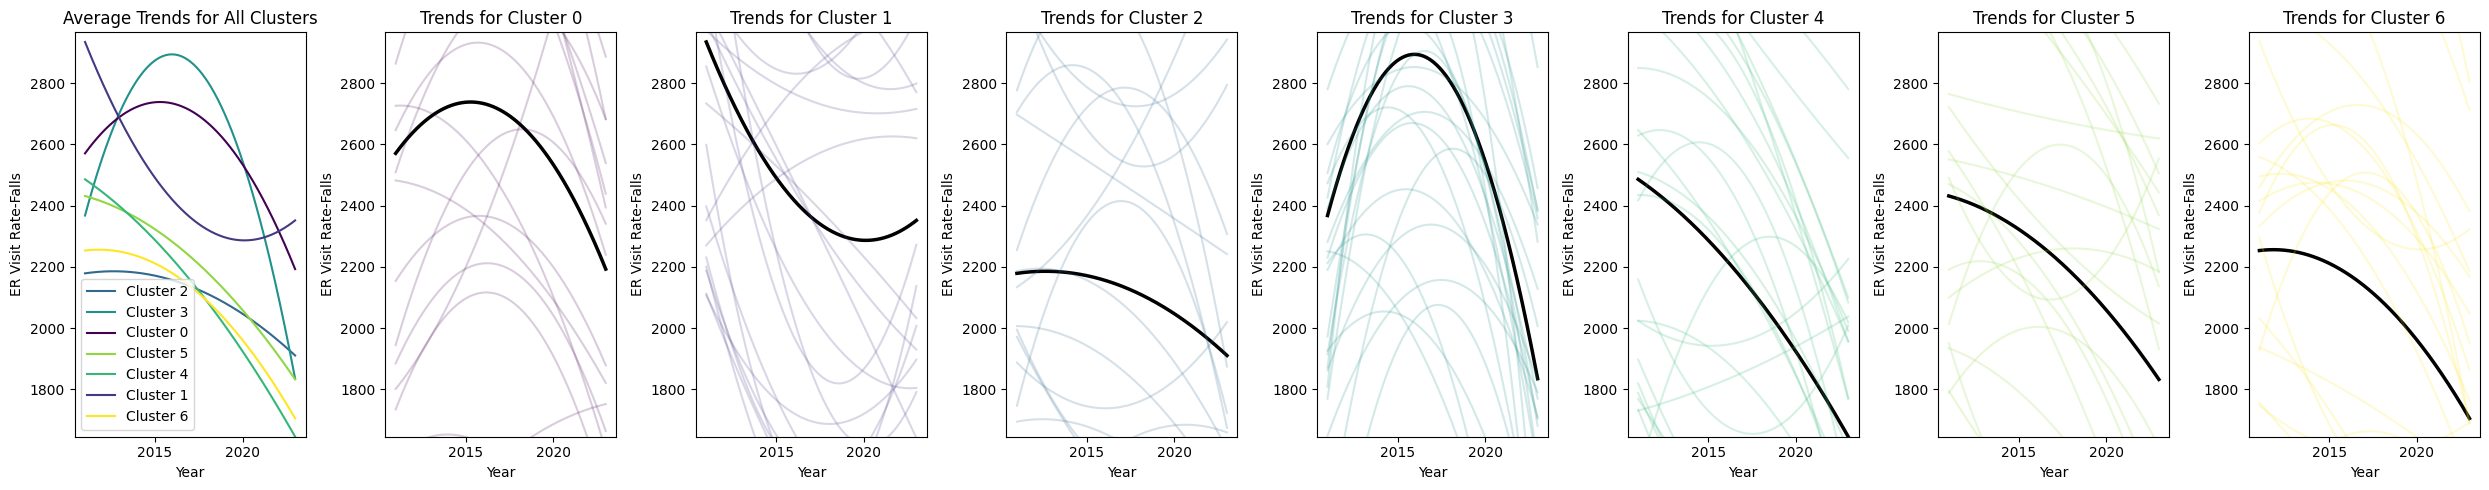

In [29]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

def plot_trend_lines(data, feature_name, clusters, cluster_color_map):
    plt.figure(figsize=(25, 5))  # Adjust the figure size for a single row
    
    # Global min/max determination
    global_min = float('inf')
    global_max = float('-inf')

    # Calculate global min and max from the average plot data
    for cluster in clusters:
        cluster_data = data[data['Cluster'] == cluster]
        mean_data = cluster_data.groupby('Year')[feature_name].mean().reset_index()
        mean_data.dropna(subset=[feature_name], inplace=True)
        
        if not mean_data.empty:
            current_min = mean_data[feature_name].min()
            current_max = mean_data[feature_name].max()
            global_min = min(global_min, current_min)
            global_max = max(global_max, current_max)

    # Plot 1: All clusters average
    ax1 = plt.subplot(1, len(clusters) + 1, 1)  # Adjust subplot for single row
    for cluster in clusters:
        cluster_data = data[data['Cluster'] == cluster]
        mean_data = cluster_data.groupby('Year')[feature_name].mean().reset_index()
        mean_data.dropna(subset=[feature_name], inplace=True)
        
        if not mean_data.empty:
            X = mean_data['Year'].values.reshape(-1, 1)
            Y = mean_data[feature_name]
            model = make_pipeline(PolynomialFeatures(2), LinearRegression())
            model.fit(X, Y)
            X_seq = np.linspace(X.min(), X.max(), 300).reshape(-1, 1)
            ax1.plot(X_seq, model.predict(X_seq), label=f"Cluster {cluster}", color=cluster_color_map[cluster])

    ax1.set_title("Average Trends for All Clusters")
    ax1.set_xlabel("Year")
    ax1.set_ylabel(feature_name)
    ax1.set_ylim(global_min, global_max)
    ax1.legend()

    # Plots 2-N: Individual clusters with darker average line
    for i, cluster in enumerate(sorted(clusters), start=2):
        ax = plt.subplot(1, len(clusters) + 1, i)
        cluster_data = data[data['Cluster'] == cluster]
        
        mean_data = cluster_data.groupby('Year')[feature_name].mean().reset_index()
        mean_data.dropna(subset=[feature_name], inplace=True)
        
        if not mean_data.empty:
            X = mean_data['Year'].values.reshape(-1, 1)
            Y = mean_data[feature_name]
            model = make_pipeline(PolynomialFeatures(2), LinearRegression())
            model.fit(X, Y)
            X_seq = np.linspace(X.min(), X.max(), 300).reshape(-1, 1)
            ax.plot(X_seq, model.predict(X_seq), label="Average", color='black', linewidth=2.5)
            
            for county in cluster_data['County'].unique():
                county_data = cluster_data[cluster_data['County'] == county]
                county_data.dropna(subset=[feature_name], inplace=True)
                
                if not county_data.empty and len(county_data) > 1:
                    X = county_data['Year'].values.reshape(-1, 1)
                    Y = county_data[feature_name]
                    model.fit(X, Y)
                    X_seq = np.linspace(X.min(), X.max(), 300).reshape(-1, 1)
                    ax.plot(X_seq, model.predict(X_seq), color=cluster_color_map[cluster], alpha=0.2)

        ax.set_title(f"Trends for Cluster {cluster}")
        ax.set_xlabel("Year")
        ax.set_ylabel(feature_name)
        ax.set_ylim(global_min, global_max)

    plt.tight_layout()
    plt.show()

# Assuming 'filtered_data_table' and 'coefficients_df_cleaned' are correctly defined and available
clusters = coefficients_df_cleaned['Cluster'].unique()
cluster_color_map = {cluster: plt.cm.get_cmap('viridis', len(clusters))(i) for i, cluster in enumerate(sorted(clusters))}
plot_trend_lines(filtered_data_table, "ER Visit Rate-Falls", clusters, cluster_color_map)


Comparison params: KMeans k=3, Agg linkage=complete k=2, DBSCAN grid-searched per space (noise cap=30%)

TABLE 1: Native-Space Metrics
  (Computed in the SAME space used for clustering. NOT directly
   comparable across spaces — included for transparency only.)
                       space                        method  n_clusters  noise_pct  silhouette  davies_bouldin  calinski_harabasz                                         cluster_sizes
                Raw PCA (5D)                  KMeans (k=3)           3   0.000000    0.161207        1.780381          24.155817                                 {0: 69, 1: 69, 2: 15}
                Raw PCA (5D) Agglomerative (complete, k=2)           2   0.000000    0.480746        1.288990          10.006349                                        {0: 150, 1: 3}
                Raw PCA (5D)        DBSCAN (eps=5.5, ms=2)           2   0.013072    0.483744        0.656065          11.131357                                        {0: 149, 1: 2}
GCN em

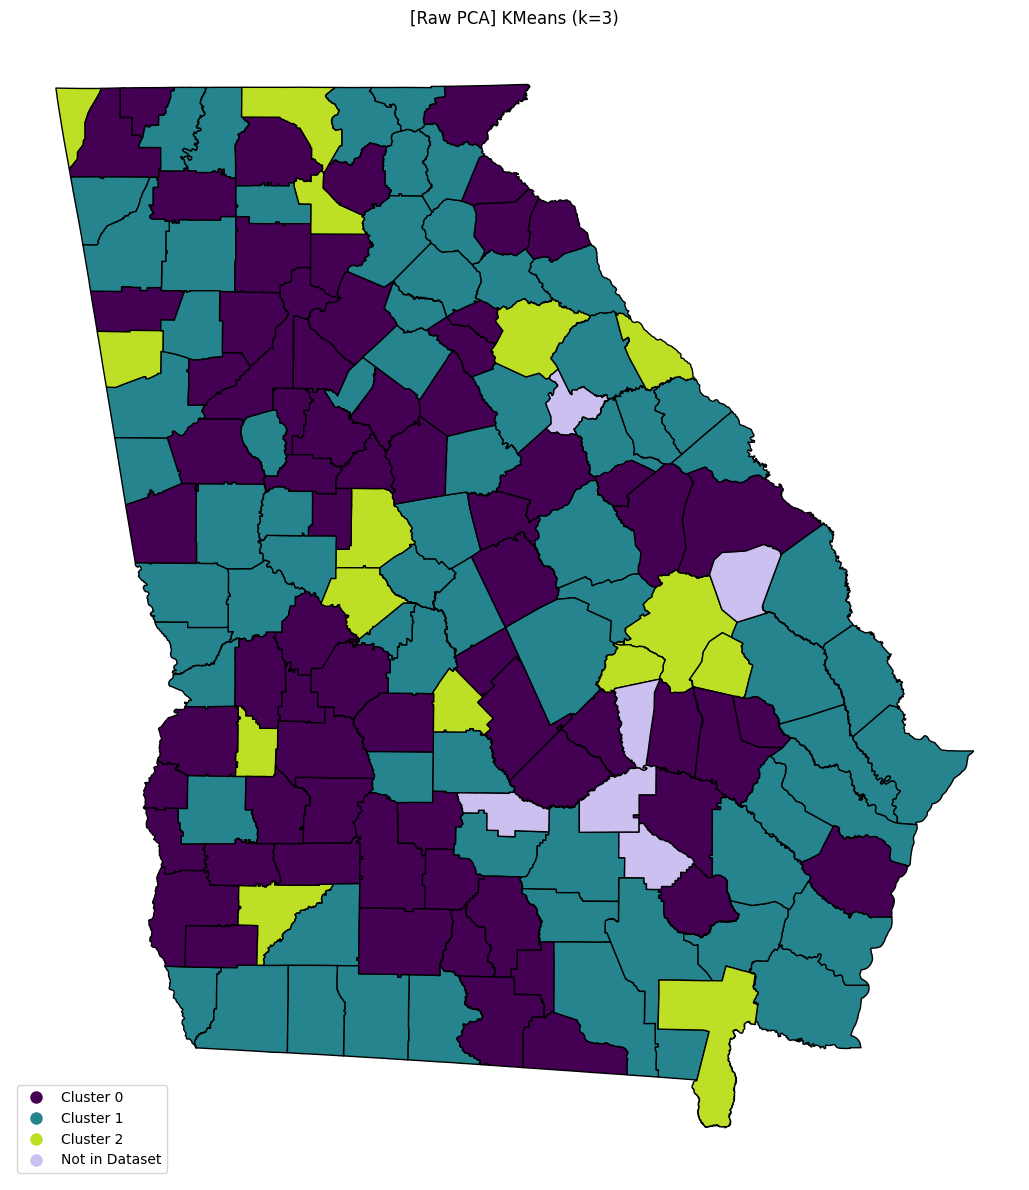

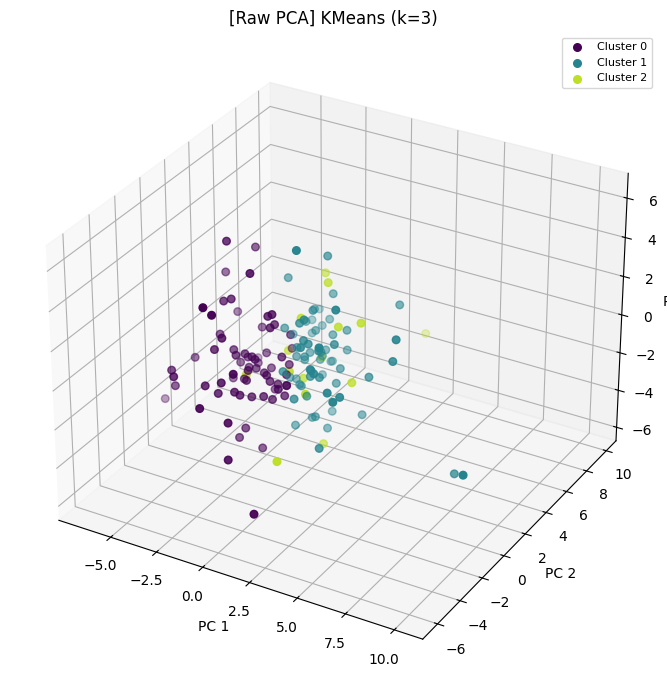

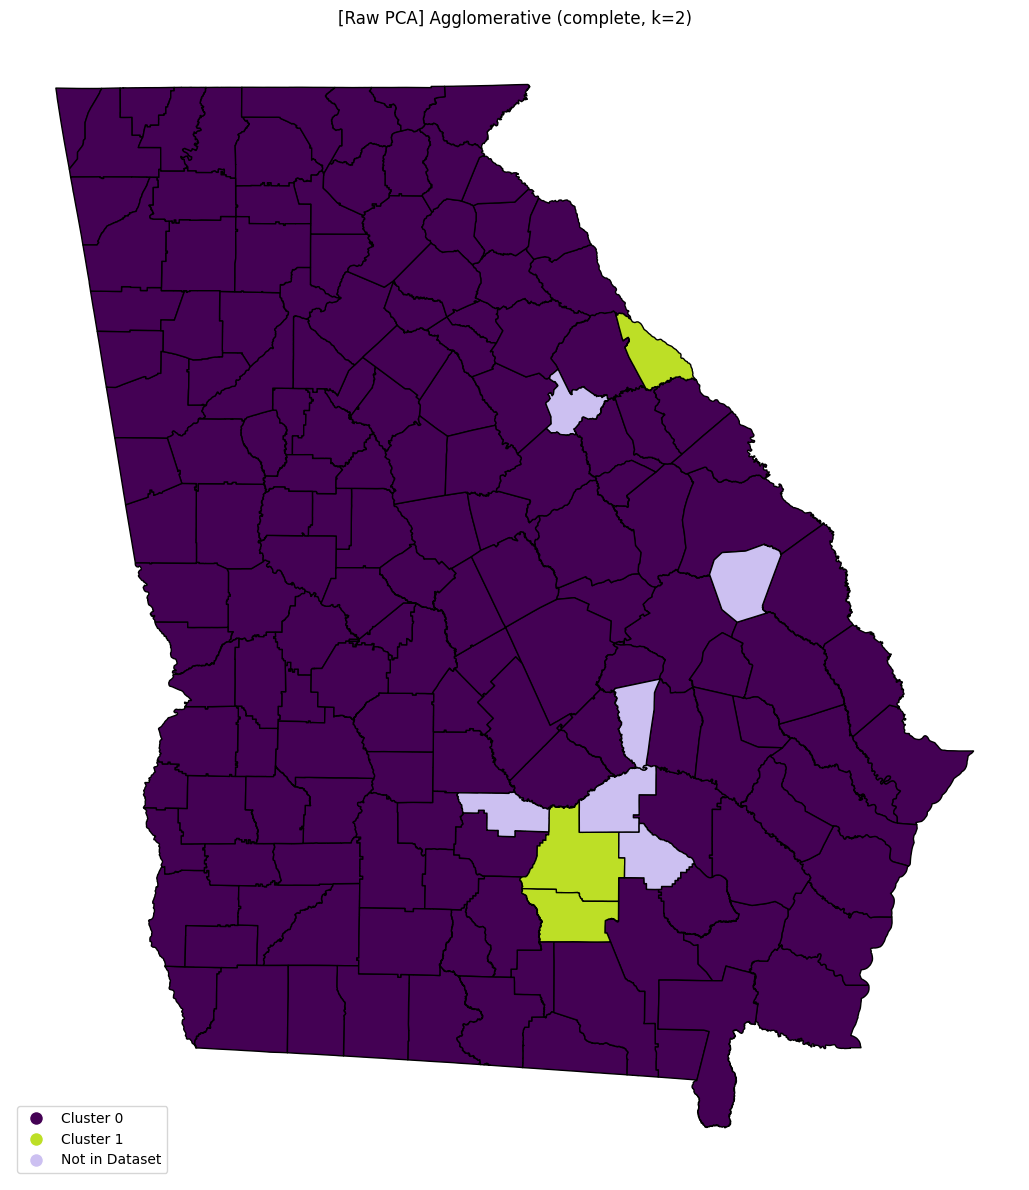

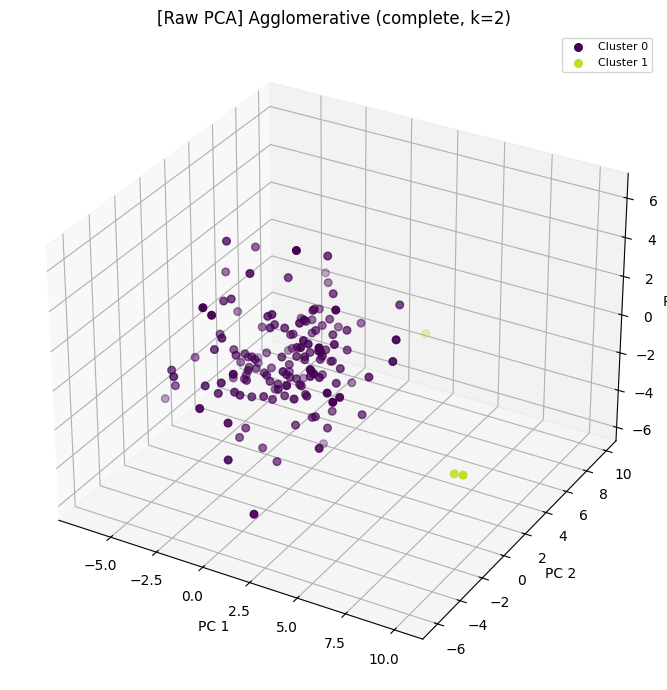

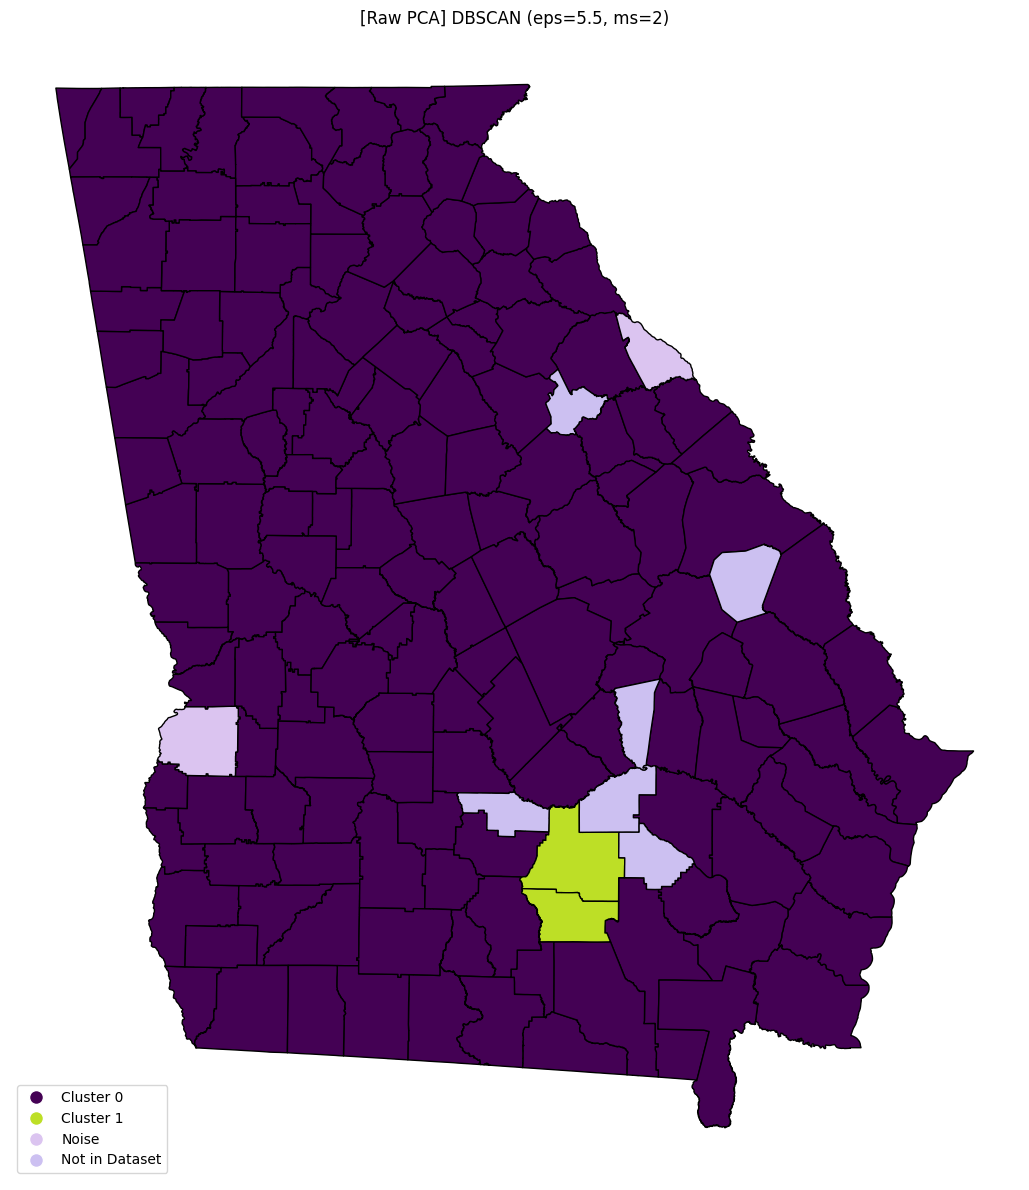

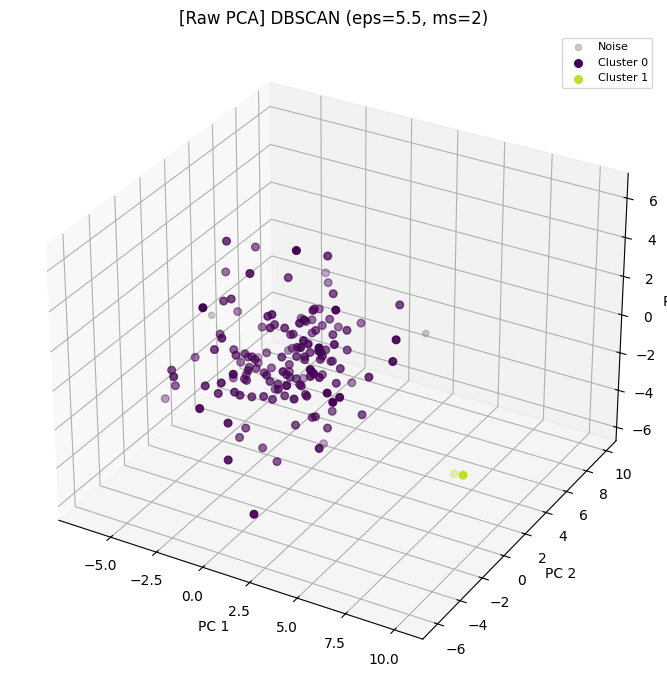


--- GCN Embedding Space ---


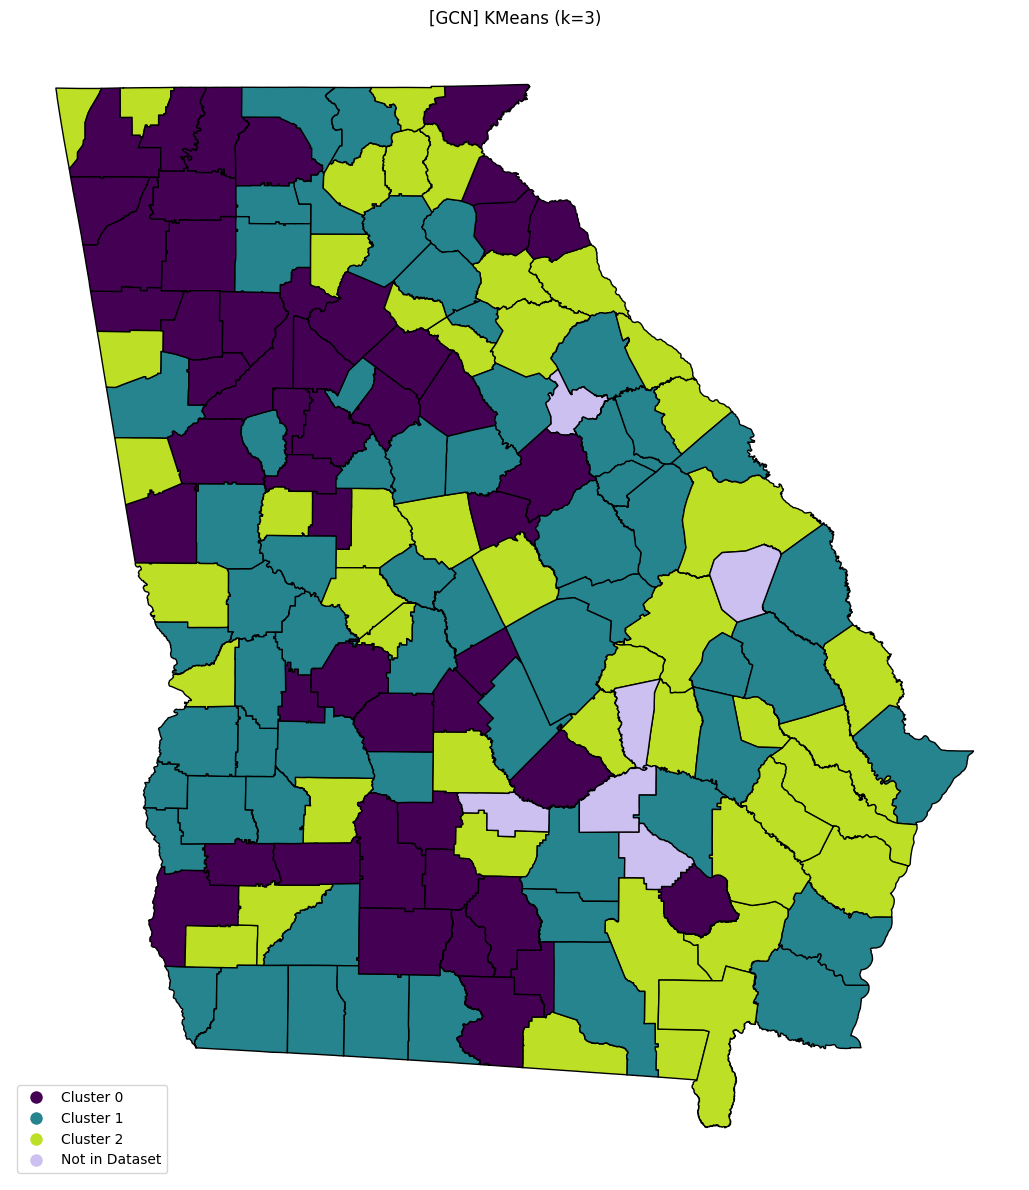

/Users/nikitajha/Documents/NikitaFinal/Coding Projects/Bastos Lab/my_new_env/lib/python3.9/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


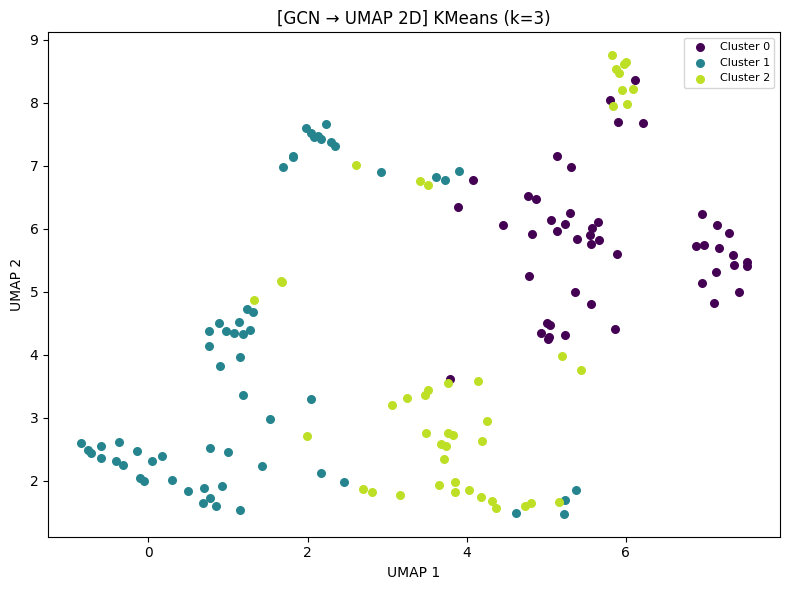

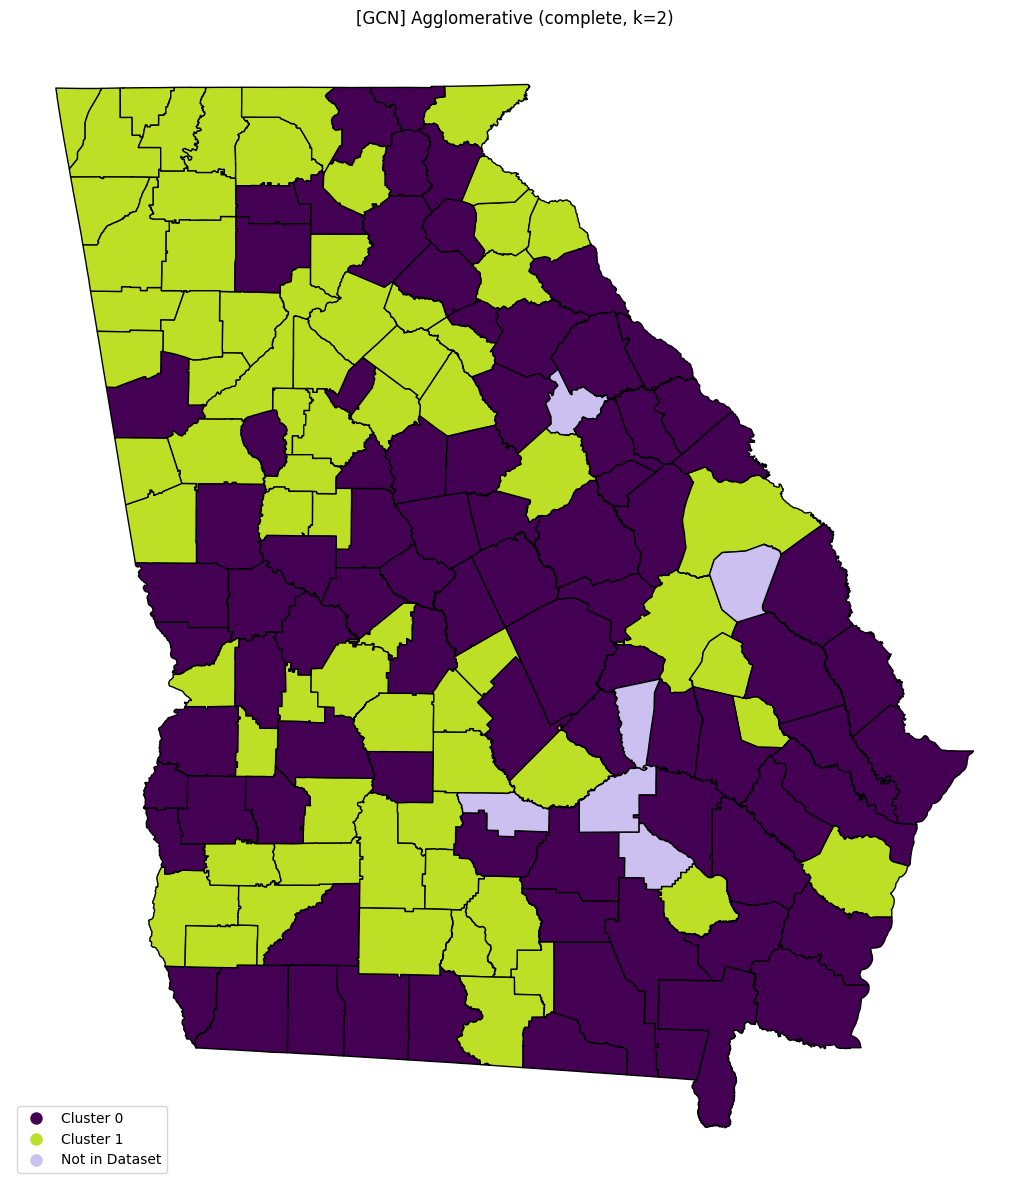

/Users/nikitajha/Documents/NikitaFinal/Coding Projects/Bastos Lab/my_new_env/lib/python3.9/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


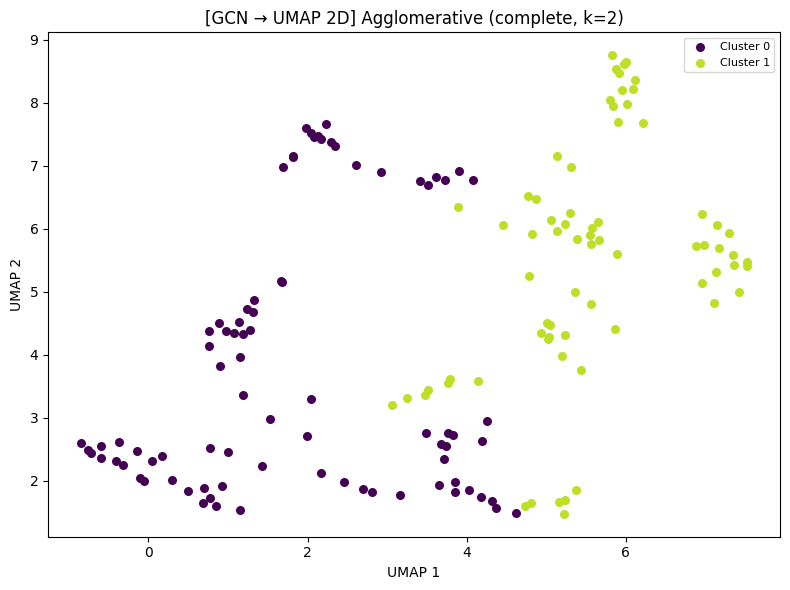

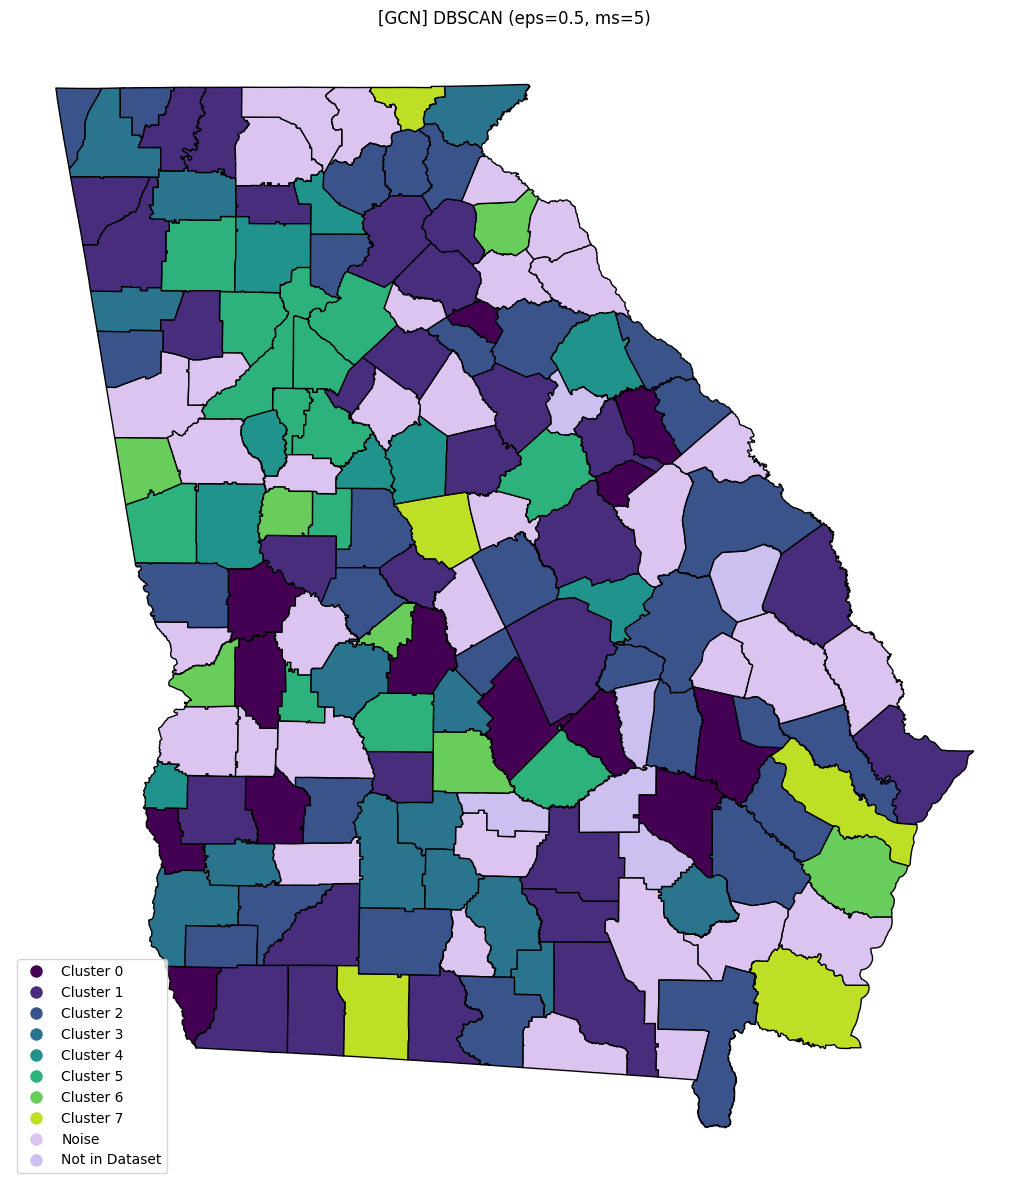

/Users/nikitajha/Documents/NikitaFinal/Coding Projects/Bastos Lab/my_new_env/lib/python3.9/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


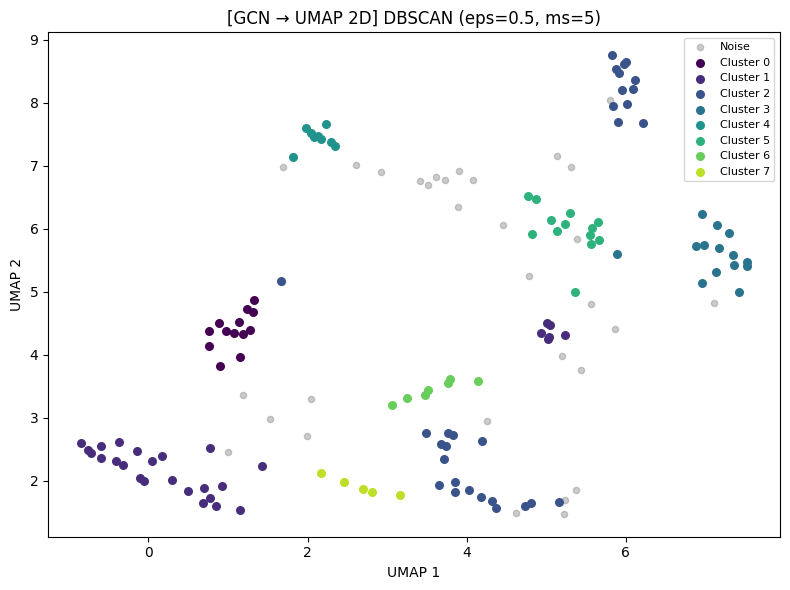

In [30]:
# ==========================================================================
# Comparison block: Raw PCA features vs GCN embeddings across clustering
# methods.  Produces a side-by-side table AND Georgia maps for all combos.
#
# Key design choices:
#   • KMeans & Agglomerative use the SAME k/linkage found by earlier cells
#     so the ONLY variable is the data representation (fair comparison).
#   • DBSCAN is grid-searched per space because eps doesn't transfer across
#     different dimensionalities (5-D PCA vs 64-D GCN).
#
# *** NEW: COMMON-SPACE METRICS ***
#   In addition to the "native" metrics (computed in whatever space the
#   method used), we also compute silhouette/DBI/CH on the ORIGINAL
#   standardized 30-D coefficient features for EVERY clustering result.
#
#   WHY THIS MATTERS:
#   When you compute silhouette in 5-D PCA space and compare it to
#   silhouette in 64-D GCN latent space, you are NOT comparing apples
#   to apples.  Distances behave very differently in different dimensions.
#   In high-dimensional spaces (like 64-D), points tend to become
#   equidistant (the "curse of dimensionality"), which can artificially
#   inflate metrics like silhouette — making clusters LOOK better than
#   they really are.
#
#   By evaluating ALL label sets on the SAME feature space (the original
#   30-D standardized coefficients), we use a single "ruler" for every
#   method.  This is the fair comparison that a reviewer would expect.
#   Think of it as: "Regardless of HOW you found the clusters, how well
#   do they separate counties in the original data?"
#
#   The "native space" column tells you how well the method works
#   internally.  The "common space" column tells you how meaningful
#   the clusters are in terms of the actual health-metric trends.
# ==========================================================================

import numpy as np
import pandas as pd
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

# --- Pull params from the individual cells (no hard-coding!) ---------------
COMP_KMEANS_K = kmeans_k                # set in Cell 11
COMP_AGG_K = agg_search["k"]            # set in Cell 18
COMP_AGG_LINKAGE = agg_search["linkage"]
DBSCAN_EPS_VALUES = np.arange(0.5, 15, 0.5)
DBSCAN_MIN_SAMPLES_VALUES = range(2, 25)
DBSCAN_NOISE_CAP = 0.30

print(f"Comparison params: KMeans k={COMP_KMEANS_K}, "
      f"Agg linkage={COMP_AGG_LINKAGE} k={COMP_AGG_K}, "
      f"DBSCAN grid-searched per space (noise cap={DBSCAN_NOISE_CAP:.0%})")

# --- Build data spaces -----------------------------------------------------
feature_cols = [c for c in coefficients_df_cleaned.columns
                if c not in ('County', 'Cluster')]
X_raw = coefficients_df_cleaned[feature_cols].values      # 30-D (common space)
pca = PCA(n_components=PCA_COMPONENTS)
X_raw_pca = pca.fit_transform(X_raw)                      # 5-D PCA
X_gcn = embeddings4                                        # 64-D GCN latent
county_names = coefficients_df_cleaned['County'].values


# --- Metrics helper --------------------------------------------------------
def compute_metrics(X, labels, noise_label=None):
    """Compute silhouette, DBI, CH on the given space X."""
    labels = np.asarray(labels)
    total = len(labels)
    noise_mask = ((labels == noise_label) if noise_label is not None
                  else np.zeros(total, dtype=bool))
    n_noise = int(noise_mask.sum())
    used_mask = ~noise_mask
    unique_labels = np.unique(labels[used_mask]) if used_mask.any() else []

    if used_mask.any():
        ids, counts = np.unique(labels[used_mask], return_counts=True)
        size_map = dict(zip(ids.tolist(), counts.tolist()))
    else:
        size_map = {}

    if X is not None and len(unique_labels) >= 2:
        X_eval = X[used_mask] if noise_label is not None else X
        l_eval = labels[used_mask] if noise_label is not None else labels
        sil = silhouette_score(X_eval, l_eval)
        dbi = davies_bouldin_score(X_eval, l_eval)
        chi = calinski_harabasz_score(X_eval, l_eval)
    else:
        sil, dbi, chi = None, None, None

    return {
        "n_total": total, "n_clusters": len(unique_labels),
        "noise_pct": (n_noise / total) if noise_label is not None else 0.0,
        "cluster_sizes": size_map,
        "silhouette": sil, "davies_bouldin": dbi, "calinski_harabasz": chi,
    }


def compute_common_space_metrics(X_common, labels, noise_label=None):
    """Compute metrics on the original 30-D feature space (common ruler)."""
    labels = np.asarray(labels)
    noise_mask = ((labels == noise_label) if noise_label is not None
                  else np.zeros(len(labels), dtype=bool))
    used_mask = ~noise_mask
    unique_labels = np.unique(labels[used_mask]) if used_mask.any() else []

    if X_common is not None and len(unique_labels) >= 2:
        X_eval = X_common[used_mask] if noise_label is not None else X_common
        l_eval = labels[used_mask] if noise_label is not None else labels
        sil = silhouette_score(X_eval, l_eval)
        dbi = davies_bouldin_score(X_eval, l_eval)
        chi = calinski_harabasz_score(X_eval, l_eval)
    else:
        sil, dbi, chi = None, None, None

    return {
        "common_silhouette": sil,
        "common_davies_bouldin": dbi,
        "common_calinski_harabasz": chi,
    }


# --- Run all 3 methods on a given data space -------------------------------
def run_all_methods(X, space_label, X_common):
    """Cluster in X, evaluate in both X (native) and X_common (fair)."""
    results = []
    label_dict = {}

    # KMeans
    km_labels = KMeans(n_clusters=COMP_KMEANS_K,
                       random_state=42).fit_predict(X)
    m = compute_metrics(X, km_labels)
    m.update(compute_common_space_metrics(X_common, km_labels))
    method_tag = f"KMeans (k={COMP_KMEANS_K})"
    results.append({"space": space_label, "method": method_tag, **m})
    label_dict[method_tag] = km_labels

    # Agglomerative
    agg_labels = AgglomerativeClustering(
        n_clusters=COMP_AGG_K, linkage=COMP_AGG_LINKAGE
    ).fit_predict(X)
    m = compute_metrics(X, agg_labels)
    m.update(compute_common_space_metrics(X_common, agg_labels))
    method_tag = f"Agglomerative ({COMP_AGG_LINKAGE}, k={COMP_AGG_K})"
    results.append({"space": space_label, "method": method_tag, **m})
    label_dict[method_tag] = agg_labels

    # DBSCAN — grid-search per space (eps is scale-dependent)
    db_search = select_best_dbscan(
        X, eps_values=DBSCAN_EPS_VALUES,
        min_samples_values=DBSCAN_MIN_SAMPLES_VALUES,
        noise_cap=DBSCAN_NOISE_CAP,
    )
    if db_search["eps"] is not None:
        db_labels = DBSCAN(eps=db_search["eps"],
                           min_samples=db_search["min_samples"]).fit_predict(X)
        m = compute_metrics(X, db_labels, noise_label=-1)
        m.update(compute_common_space_metrics(X_common, db_labels,
                                              noise_label=-1))
        method_tag = (f"DBSCAN (eps={db_search['eps']:.1f}, "
                      f"ms={db_search['min_samples']})")
    else:
        db_labels = np.full(len(X), -1)
        m = compute_metrics(X, db_labels, noise_label=-1)
        m.update(compute_common_space_metrics(X_common, db_labels,
                                              noise_label=-1))
        method_tag = "DBSCAN (no valid params)"
    results.append({"space": space_label, "method": method_tag, **m})
    label_dict[method_tag] = db_labels

    return results, label_dict


# --- Execute ---------------------------------------------------------------
pca_results, pca_labels = run_all_methods(
    X_raw_pca, f"Raw PCA ({PCA_COMPONENTS}D)", X_common=X_raw)
gcn_results, gcn_labels = run_all_methods(
    X_gcn, "GCN embeddings (64-D latent)", X_common=X_raw)

comparison_df = pd.DataFrame(pca_results + gcn_results)


# --- TABLE 1: Native-space metrics (what the method "sees") ----------------
print("\n" + "=" * 90)
print("TABLE 1: Native-Space Metrics")
print("  (Computed in the SAME space used for clustering. NOT directly")
print("   comparable across spaces — included for transparency only.)")
print("=" * 90)

display_cols_native = ["space", "method", "n_clusters", "noise_pct",
                       "silhouette", "davies_bouldin", "calinski_harabasz",
                       "cluster_sizes"]
print(comparison_df[display_cols_native].to_string(index=False))


# --- TABLE 2: Common-space metrics (the fair comparison) -------------------
print("\n" + "=" * 90)
print("TABLE 2: Common-Space Metrics (Original 30-D Standardized Features)")
print("  (All label sets evaluated on the SAME feature space — this is the")
print("   fair comparison to use when comparing methods in a paper.)")
print("=" * 90)

display_cols_common = ["space", "method", "n_clusters", "noise_pct",
                       "common_silhouette", "common_davies_bouldin",
                       "common_calinski_harabasz", "cluster_sizes"]
print(comparison_df[display_cols_common].to_string(index=False))


# --- Interpretation guidance -----------------------------------------------
print("\n" + "-" * 90)
print("HOW TO READ THESE TABLES:")
print("-" * 90)
print("• Table 1 (native) shows how well clusters separate in the space")
print("  each method used internally.  GCN's high silhouette here does NOT")
print("  mean the clusters are 'better' — it partly reflects the 64-D space")
print("  compressing distances (curse of dimensionality).")
print("")
print("• Table 2 (common) is the one to CITE IN YOUR PAPER.  It answers:")
print("  'Regardless of how clusters were found, how well do they separate")
print("  counties in terms of the original health-metric trends?'")
print("")
print("• If a method has high native silhouette but LOW common silhouette,")
print("  the clusters are an artifact of the embedding, not real structure.")
print("• DBSCAN results with > 10% noise or degenerate splits (e.g., 149:2)")
print("  should be discussed as outlier detection, not meaningful clustering.")
print("-" * 90)

print("\nNotes:")
print("- KMeans & Agglomerative use the same k/linkage in both spaces.")
print("- DBSCAN eps is grid-searched per space (eps doesn't transfer).")
print("- Common-space metrics exclude noise points for DBSCAN.")


# --- Scatter-plot helper ---------------------------------------------------
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import umap as umap_lib

def plot_cluster_scatter(X, labels, title, noise_label=None, use_umap_2d=False):
    """3-D scatter (PCA) or 2-D UMAP scatter (GCN) colored by cluster."""
    labels = np.asarray(labels)
    unique = sorted(set(labels))
    n_real = len([u for u in unique if u != noise_label])
    colors = plt.cm.viridis(np.linspace(0, 0.9, max(n_real, 1)))

    if use_umap_2d:
        proj = umap_lib.UMAP(n_components=2, random_state=42).fit_transform(X)
        fig, ax = plt.subplots(figsize=(8, 6))
        color_idx = 0
        for u in unique:
            mask = labels == u
            if u == noise_label:
                ax.scatter(proj[mask, 0], proj[mask, 1],
                           c='gray', alpha=0.4, s=20, label='Noise')
            else:
                ax.scatter(proj[mask, 0], proj[mask, 1],
                           c=[colors[color_idx]], s=30, label=f'Cluster {u}')
                color_idx += 1
        ax.set_xlabel('UMAP 1')
        ax.set_ylabel('UMAP 2')
        ax.set_title(title)
        ax.legend(loc='best', fontsize=8)
        plt.tight_layout()
        plt.show()
    else:
        fig = plt.figure(figsize=(9, 7))
        ax = fig.add_subplot(111, projection='3d')
        color_idx = 0
        for u in unique:
            mask = labels == u
            if u == noise_label:
                ax.scatter(X[mask, 0], X[mask, 1], X[mask, 2],
                           c='gray', alpha=0.4, s=20, label='Noise')
            else:
                ax.scatter(X[mask, 0], X[mask, 1], X[mask, 2],
                           c=[colors[color_idx]], s=30, label=f'Cluster {u}')
                color_idx += 1
        ax.set_xlabel('PC 1')
        ax.set_ylabel('PC 2')
        ax.set_zlabel('PC 3')
        ax.set_title(title)
        ax.legend(loc='best', fontsize=8)
        plt.tight_layout()
        plt.show()


# --- Georgia maps + scatter plots for all 6 combos -------------------------
print("\n--- Raw PCA Space ---")
for method_tag, labels in pca_labels.items():
    noise_lbl = -1 if "DBSCAN" in method_tag else None
    plot_ga_cluster_map(labels, county_names,
                        title=f"[Raw PCA] {method_tag}", noise_label=noise_lbl)
    plot_cluster_scatter(X_raw_pca, labels,
                         title=f"[Raw PCA] {method_tag}",
                         noise_label=noise_lbl, use_umap_2d=False)

print("\n--- GCN Embedding Space ---")
for method_tag, labels in gcn_labels.items():
    noise_lbl = -1 if "DBSCAN" in method_tag else None
    plot_ga_cluster_map(labels, county_names,
                        title=f"[GCN] {method_tag}", noise_label=noise_lbl)
    plot_cluster_scatter(X_gcn, labels,
                         title=f"[GCN → UMAP 2D] {method_tag}",
                         noise_label=noise_lbl, use_umap_2d=True)
